In [6]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ESTRUTURA PROPOSTA:


###    1. Introdução

###    2. Project Understanding

###    3. Data Understanding
#####  3.1. Descrição
#####  3.2. EDA
#####  3.3. Correlações
#####  3.4. Qualidade dos dados

###    4. Data Preparation
#####  4.1. Limpeza
#####  4.2. Transformações
#####  4.3. Feature Engineering

###    5. Modeling
#####  5.1. Clustering
#####  5.2. Modelos de previsão
#####  5.3. Normalização

###    6. Evaluation

###    7. Conclusion

###    8. References

# 3. Data Understanding
 
O dataset utilizado corresponde ao registo contínuo de consumos energéticos de vários edifícios municipais da Maia, recolhidos através de sistemas de telemetria. As medições são efetuadas em intervalos regulares de 15 minutos, permitindo caracterizar com grande detalhe os padrões de utilização energética ao longo do tempo.
 ## 3.1 Descrição do Dataset
Cada registo do Dataset, incluí:
 - Código do local (CPE);
 - Timestamp da medição (tstamp);
 - DadosDeConsumo (kW/h);
 - Potência Ativa (kW/h);
 - Potência Reativa Indutiva (VAR);
 - Potência Reativa Capacitiva (VAR).



In [7]:
df = pl.read_csv(
    "consumo15m_11_2025.csv",
    null_values="NULL"
)

df

CPE,tstamp,DadosdeConsumo,PotActiva,PotReactIndut,PotReactCapac
str,str,str,f64,str,str
"""PT0002000089069203YG""","""2022-12-31 00:15:00""",null,0.296,null,null
"""PT0002000089069203YG""","""2022-12-31 00:30:00""",null,0.292,null,null
"""PT0002000089069203YG""","""2022-12-31 00:45:00""",null,0.284,null,null
"""PT0002000089069203YG""","""2022-12-31 01:00:00""",null,0.28,null,null
"""PT0002000089069203YG""","""2022-12-31 01:15:00""",null,0.272,null,null
…,…,…,…,…,…
"""PT0002000110607652SB""","""2025-04-30 23:00:00""",null,3.0,"""1.000""","""0.000"""
"""PT0002000110607652SB""","""2025-04-30 23:15:00""",null,3.0,"""2.000""","""0.000"""
"""PT0002000110607652SB""","""2025-04-30 23:30:00""",null,3.0,"""1.000""","""0.000"""



# 3.2 Limpeza Inicial e Conversão de Tipos
 Antes de proceder à análise, é essencial garantir:
 - conversão do timestamp para formato datetime;
 - conversão das colunas numéricas para float;
 - eliminação/tratamento dos valores "NULL".
 
Estas etapas são fundamentais, pois garantem a consistência do dataset e permitem realizar operações estatísticas e temporais de forma correta. Após esta limpeza, os dados ficam prontos para uma exploração detalhada e fiável.

In [8]:
df = df.with_columns(
    pl.col("tstamp").str.to_datetime("%Y-%m-%d %H:%M:%S")
)

df = df.with_columns([
    pl.col("DadosdeConsumo").cast(pl.Float64),
    pl.col("PotReactIndut").cast(pl.Float64),
    pl.col("PotReactCapac").cast(pl.Float64),
])

df.dtypes

[String,
 Datetime(time_unit='us', time_zone=None),
 Float64,
 Float64,
 Float64,
 Float64]

# 3.3 Análise Descritiva e Visualização

Nesta fase, são calculadas as principais métricas estatísticas, como média, desvio padrão, valores mínimos e máximos. Esta análise, complementada por histogramas, permite uma compreensão inicial da distribuição e da escala das variáveis, sendo fundamental para detetar anomalias, como outliers ou valores inesperados.

In [9]:
df.describe().transpose(include_header=True, header_name="statistic", column_names="statistic")

statistic,count,null_count,mean,std,min,25%,50%,75%,max
str,str,str,str,str,str,str,str,str,str
"""CPE""","""5940182""","""0""",null,null,"""PT0002000032936306KX""",null,null,null,"""PT0002000201936109ME"""
"""tstamp""","""5940182""","""0""","""2024-04-15 22:32:26.636113""",null,"""2022-12-31 00:15:00""","""2023-09-28 05:00:00""","""2024-05-15 14:00:00""","""2024-11-08 01:00:00""","""2025-05-01 00:00:00"""
"""DadosdeConsumo""","""0.0""","""5940182.0""",null,null,null,null,null,null,null
"""PotActiva""","""5940182.0""","""0.0""","""8.093966159622719""","""23.018326816845473""","""0.0""","""0.12""","""2.0""","""7.0""","""574.0"""
"""PotReactIndut""","""3668710.0""","""2271472.0""","""1.7153228246440848""","""3.385570409509408""","""0.0""","""0.0""","""0.0""","""2.0""","""177.0"""
"""PotReactCapac""","""3668710.0""","""2271472.0""","""0.6525601641994052""","""1.6623693221226727""","""0.0""","""0.0""","""0.0""","""1.0""","""124.0"""


In [10]:
df.select(pl.col("CPE").n_unique())

CPE
u32
91


O conjunto de dados contém 91 CPEs distintos.

In [11]:
# missing por coluna
df.null_count()

CPE,tstamp,DadosdeConsumo,PotActiva,PotReactIndut,PotReactCapac
u32,u32,u32,u32,u32,u32
0,0,5940182,0,2271472,2271472


In [12]:
# percentagem de zeros na PotActiva
total = df.height
zeros = df.filter(pl.col("PotActiva") == 0).height
print(f"Percentagem de PotActiva = 0: {zeros / total * 100} %")

Percentagem de PotActiva = 0: 14.897220320858857 %


A análise inicial revelou que a variável DadosdeConsumo se encontra totalmente nula, pelo que não será útil na modelação inicial. Verificou-se ainda que cerca de 15% dos valores de PotActiva são zero, o que indica longos períodos de baixa atividade energética. Também é possivel reparar na falta de valores de potência reativa indutiva e condutiva para ~~certas secções das séries temporais~~ criando buracos na informação

## Outlier

## Análise de Histogramas


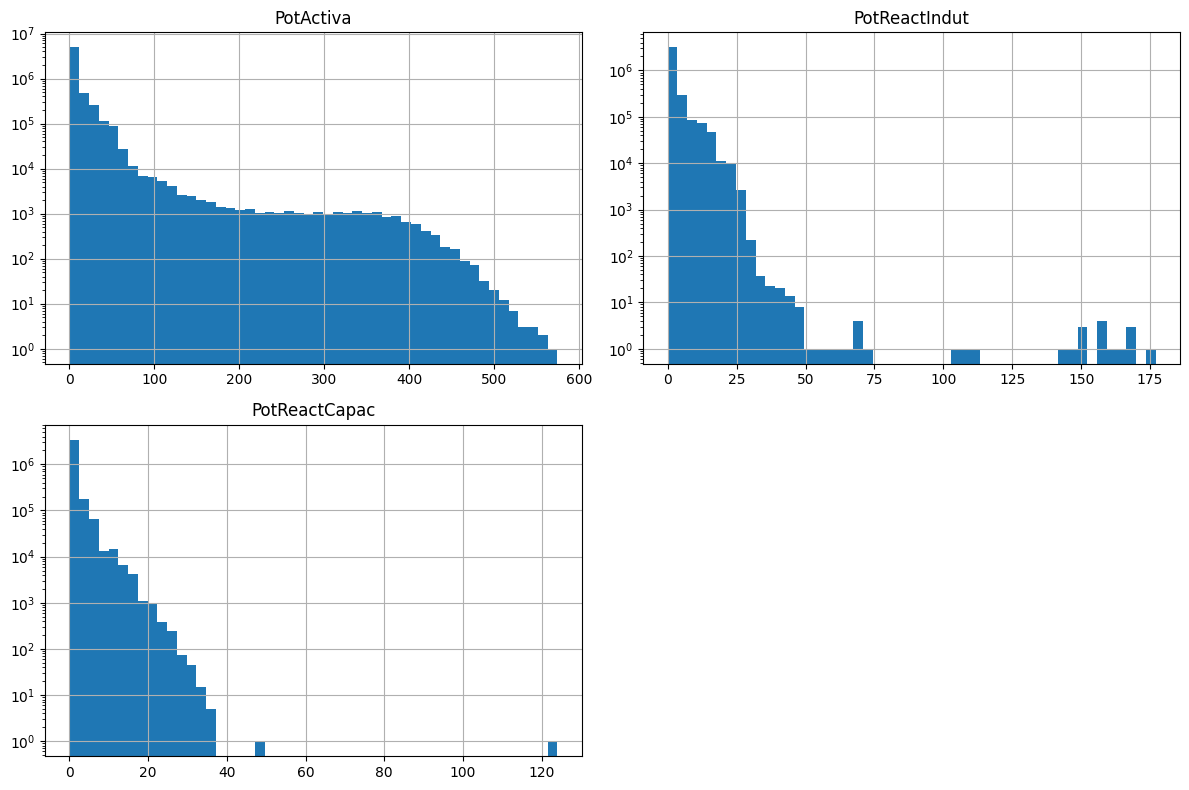

In [13]:
histo = df.select([
    "PotActiva",
    "PotReactIndut",
    "PotReactCapac"
]).to_pandas()

histo.hist(bins=50, figsize=(12,8), log=True)
plt.tight_layout()
plt.show()

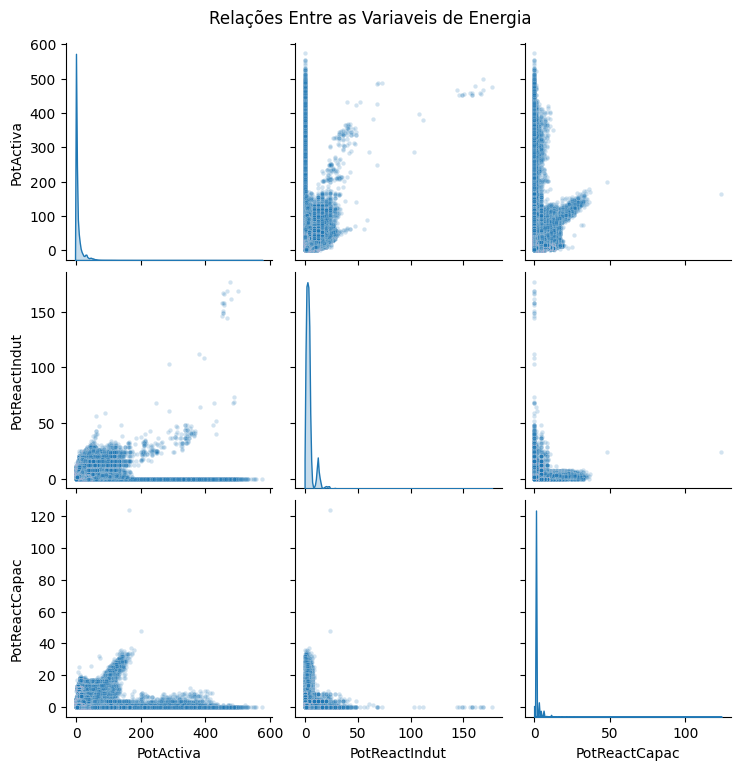

In [14]:
sns.pairplot(
    histo,
    diag_kind="kde",
    plot_kws={"alpha": 0.2, "s": 10} 
)
plt.suptitle("Relações Entre as Variaveis de Energia", y=1.02)
plt.show()

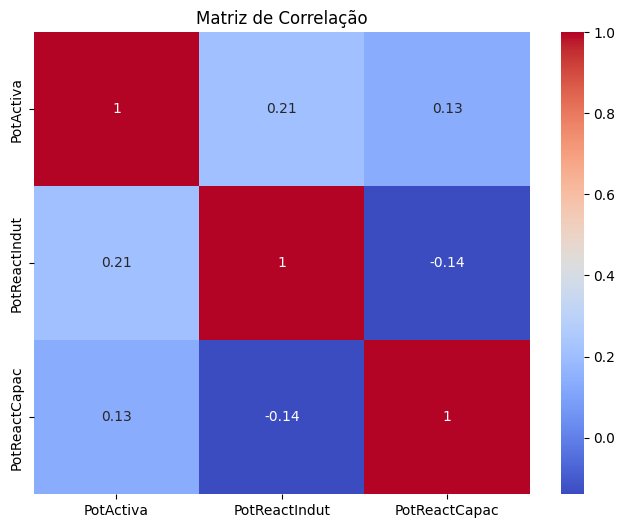

In [15]:
plt.figure(figsize=(8,6))
sns.heatmap(histo.corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

A matriz de correlação mostra que as três variáveis energéticas analisadas têm uma relação fraca entre si. A potência ativa apresenta apenas uma correlação ligeiramente positiva com a potência reativa indutiva (0.21) e uma ainda mais baixa com a componente capacitiva (0.13). Isto significa que, mesmo quando a potência ativa aumenta, as componentes reativas nem sempre acompanham esse aumento de forma clara ou consistente. Também se observa uma correlação fraca e negativa entre a potência reativa indutiva e capacitiva (-0.14).
No geral, estes valores mostram que as variáveis não são redundantes e captam dimensões distintas do comportamento elétrico dos edifícios, o que as torna úteis para as fases seguintes de preparação e modelação dos dados.

## Análise Temporal
Como o dataset inclui timestamps, é útil analisar o comportamento das variáveis ao longo do tempo permitindo:
<p>-identificar padrões diários e semanais;<p>
-ajudar a perceber períodos de maior e menor atividade; <p>
-facilitar a deteção de picos, anomalias e variações sazonais;



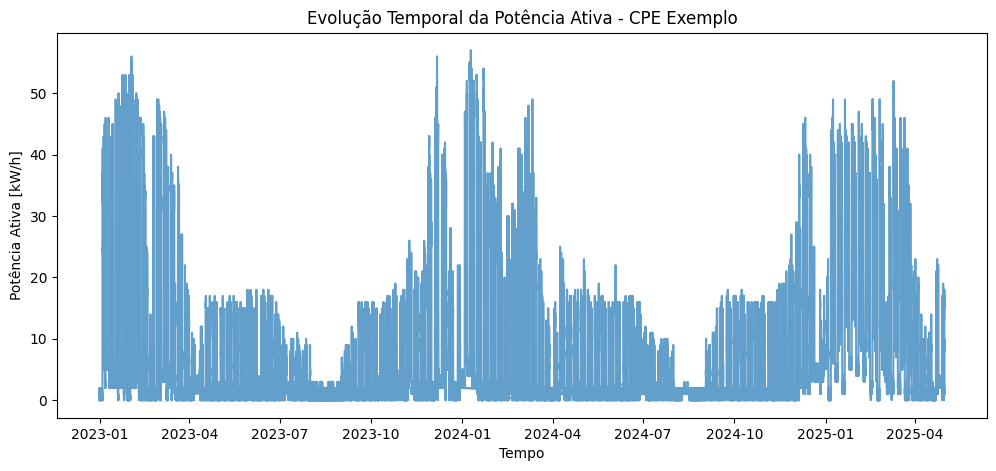

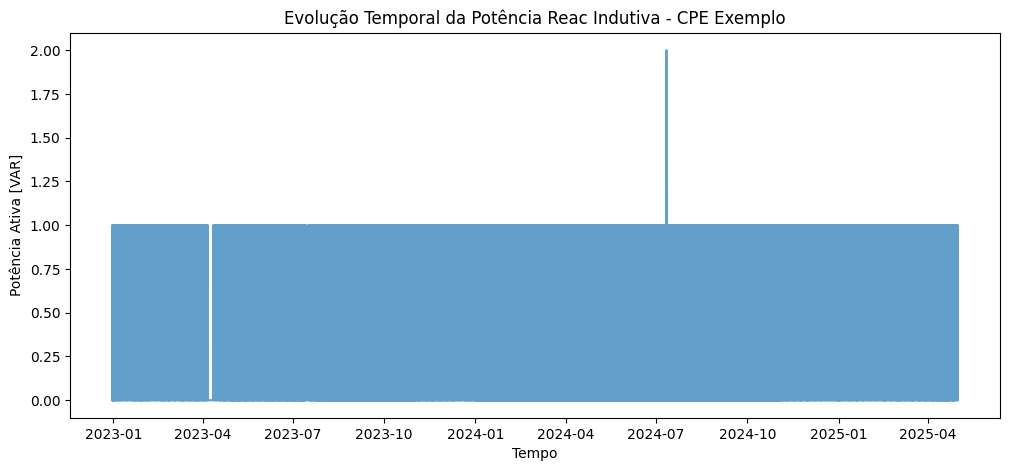

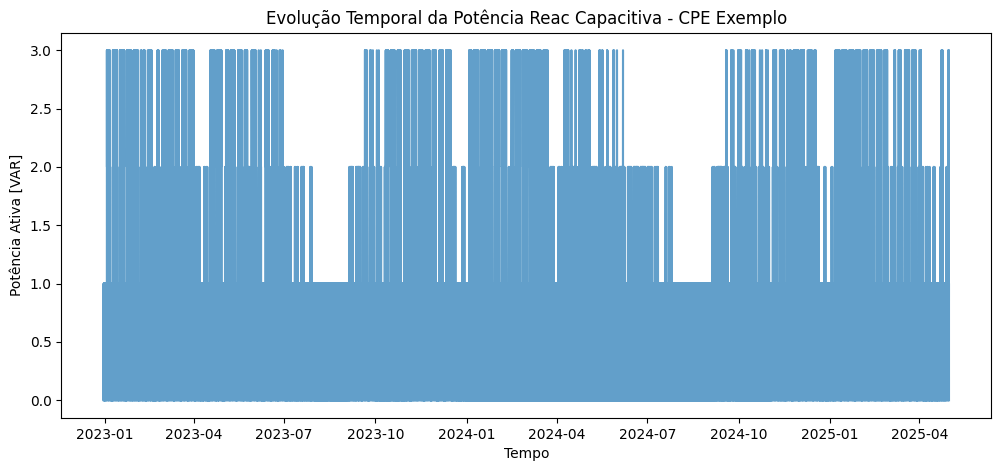

In [16]:
sample_cpe = df.filter(pl.col("CPE") == df["CPE"][1000000])  # escolher 1 edificio
pdf = sample_cpe.to_pandas()

plt.figure(figsize=(12,5))
plt.plot(pdf["tstamp"], pdf["PotActiva"], alpha=0.7)
plt.title("Evolução Temporal da Potência Ativa - CPE Exemplo")
plt.xlabel("Tempo")
plt.ylabel("Potência Ativa [kW/h]")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(pdf["tstamp"], pdf["PotReactIndut"], alpha=0.7)
plt.title("Evolução Temporal da Potência Reac Indutiva - CPE Exemplo")
plt.xlabel("Tempo")
plt.ylabel("Potência Ativa [VAR]")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(pdf["tstamp"], pdf["PotReactCapac"], alpha=0.7)
plt.title("Evolução Temporal da Potência Reac Capacitiva - CPE Exemplo")
plt.xlabel("Tempo")
plt.ylabel("Potência Ativa [VAR]")
plt.show()

### Perfis Diários, semanais e mensais

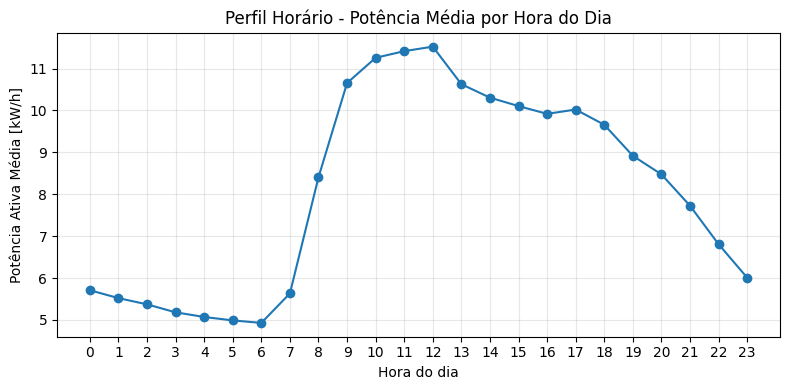

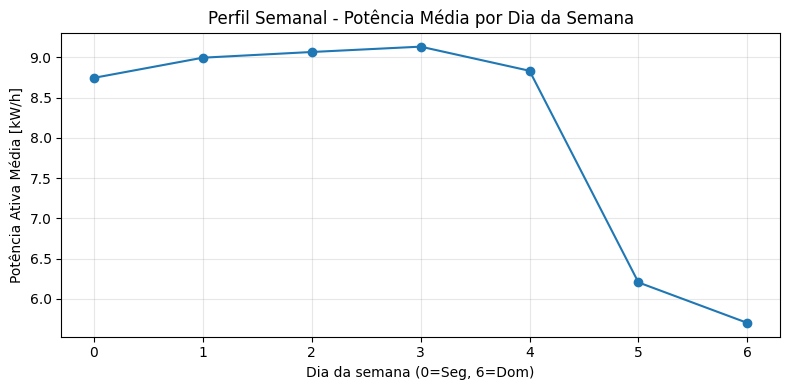

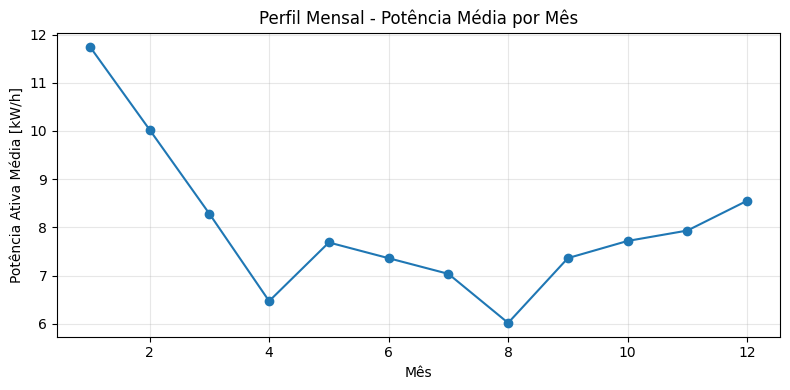

In [17]:
# Perfil Diário
pdf = df.to_pandas()
pdf["hour"] = pdf["tstamp"].dt.hour

hourly = pdf.groupby("hour")["PotActiva"].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(hourly["hour"], hourly["PotActiva"], marker="o")
plt.xlabel("Hora do dia")
plt.ylabel("Potência Ativa Média [kW/h]")
plt.title("Perfil Horário - Potência Média por Hora do Dia")
plt.xticks(range(0,24))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Perfil Semanal
pdf["weekday"] = pdf["tstamp"].dt.weekday  

weekly = pdf.groupby("weekday")["PotActiva"].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(weekly["weekday"], weekly["PotActiva"], marker="o")
plt.xlabel("Dia da semana (0=Seg, 6=Dom)")
plt.ylabel("Potência Ativa Média [kW/h]")
plt.title("Perfil Semanal - Potência Média por Dia da Semana")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Perfil Mensal
pdf["month"] = pdf["tstamp"].dt.month

monthly = pdf.groupby("month")["PotActiva"].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(monthly["month"], monthly["PotActiva"], marker="o")
plt.xlabel("Mês")
plt.ylabel("Potência Ativa Média [kW/h]")
plt.title("Perfil Mensal - Potência Média por Mês")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



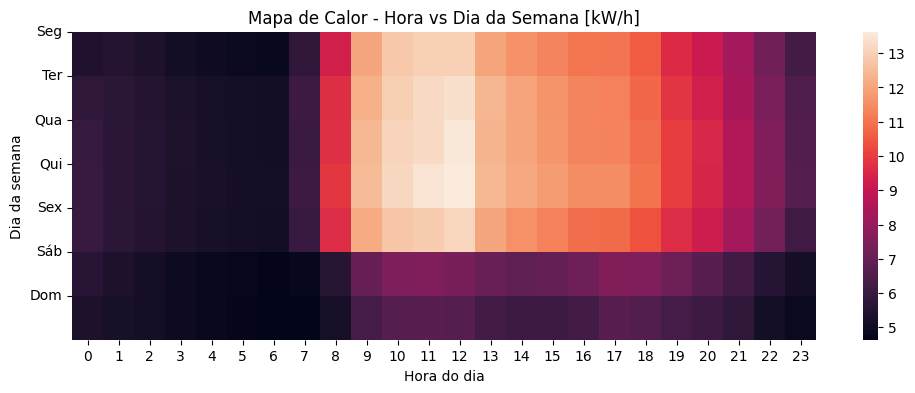

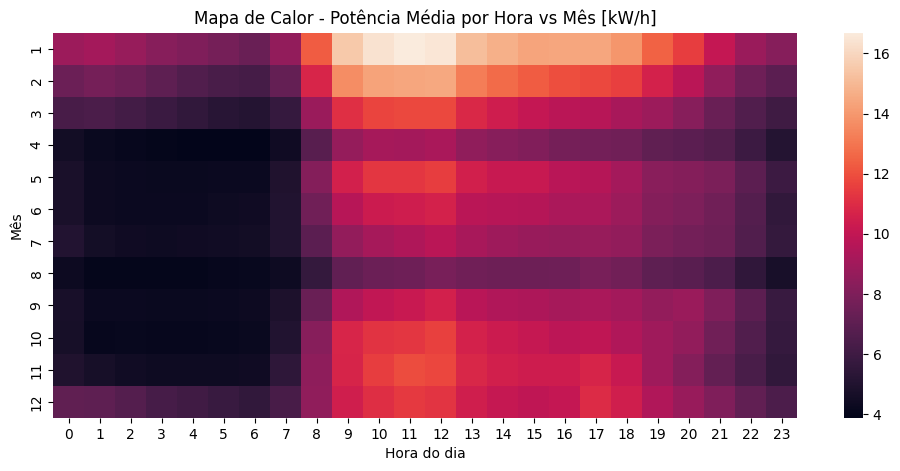

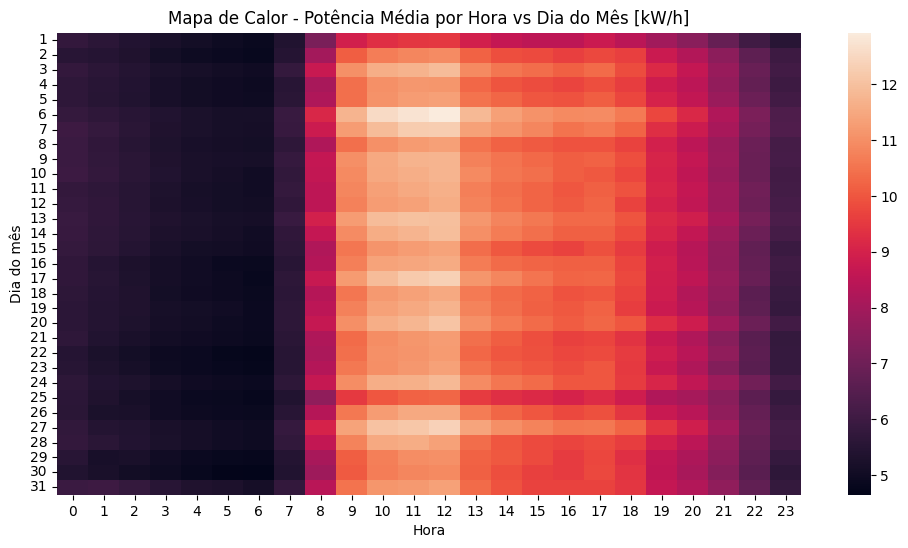

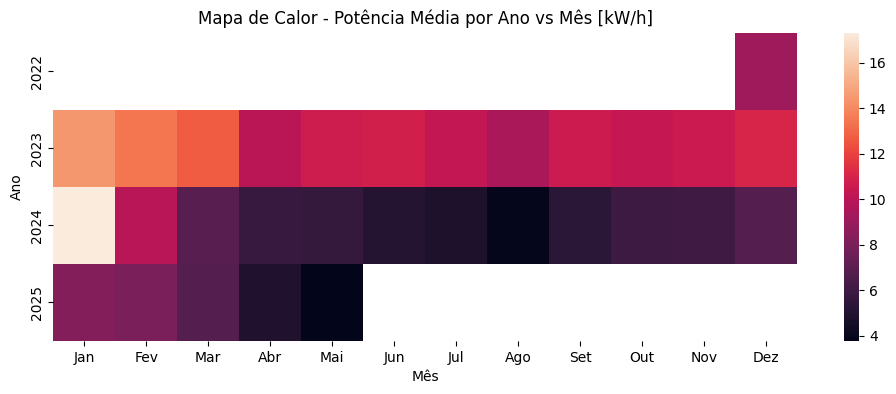

In [18]:

pdf["year"] = pdf["tstamp"].dt.year
pdf["month"] = pdf["tstamp"].dt.month
pdf["weekday"] = pdf["tstamp"].dt.weekday
pdf["hour"] = pdf["tstamp"].dt.hour
pdf["day"] = pdf["tstamp"].dt.day
pivot = pdf.pivot_table(
    values="PotActiva",
    index="weekday",
    columns="hour",
    aggfunc="mean"
)

plt.figure(figsize=(12,4))
sns.heatmap(pivot, cmap="rocket")

# Títulos
plt.title("Mapa de Calor - Hora vs Dia da Semana [kW/h]")
plt.xlabel("Hora do dia")
plt.ylabel("Dia da semana")

# Substituir 0..6 pelos nomes
dias = ["Seg", "Ter", "Qua", "Qui", "Sex", "Sáb", "Dom"]
plt.yticks(ticks=range(7), labels=dias, rotation=0)

pivot_month_hour = pdf.pivot_table(
    values="PotActiva",
    index="month",
    columns="hour",
    aggfunc="mean"
)

plt.figure(figsize=(12,5))
sns.heatmap(pivot_month_hour, cmap="rocket")
plt.title("Mapa de Calor - Potência Média por Hora vs Mês [kW/h]")
plt.xlabel("Hora do dia")
plt.ylabel("Mês")
plt.show()


pivot_day_hour = pdf.pivot_table(
    values="PotActiva",
    index="day",
    columns="hour",
    aggfunc="mean"
)

plt.figure(figsize=(12,6))
sns.heatmap(pivot_day_hour, cmap="rocket")
plt.title("Mapa de Calor - Potência Média por Hora vs Dia do Mês [kW/h]")
plt.xlabel("Hora")
plt.ylabel("Dia do mês")
plt.show()



pivot_year_month = pdf.pivot_table(
    values="PotActiva",
    index="year",
    columns="month",
    aggfunc="mean"
)
meses = ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun",
         "Jul", "Ago", "Set", "Out", "Nov", "Dez"]

plt.figure(figsize=(12,4))
sns.heatmap(pivot_year_month, cmap="rocket", 
            xticklabels=meses)
plt.title("Mapa de Calor - Potência Média por Ano vs Mês [kW/h]")
plt.xlabel("Mês")
plt.ylabel("Ano")
plt.show()

Top 3 CPE com maior consumo total: ['PT0002000078441876HB', 'PT0002000100113293JT', 'PT0002000068856781NM']


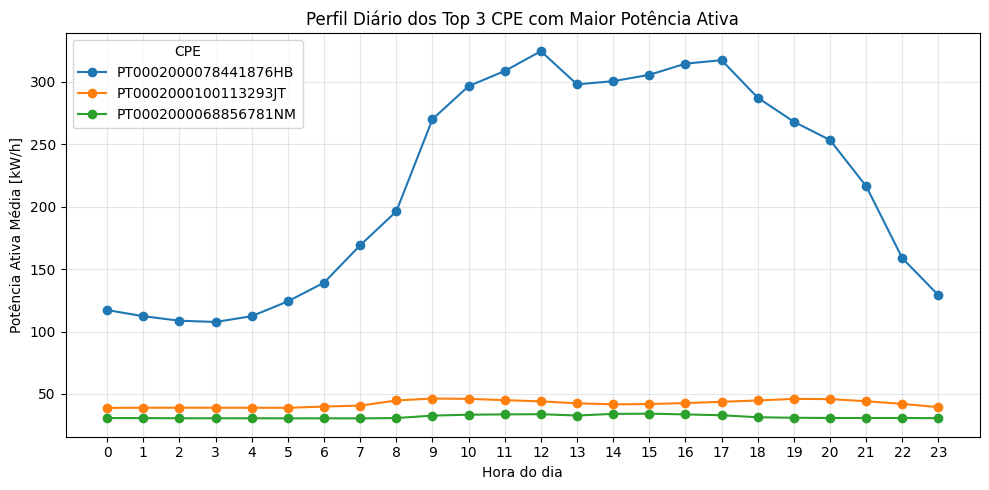

In [19]:
top3 = (
    df.group_by("CPE")
      .agg(pl.col("PotActiva").sum().alias("total"))
      .sort("total", descending=True)
      .head(3)
      .to_pandas()
)

top3_list = top3["CPE"].tolist()
print("Top 3 CPE com maior consumo total:", top3_list)

# Filtrar apenas CPE do Top 3
pdf_top = pdf[pdf["CPE"].isin(top3_list)]

perfis = (
    pdf_top.groupby(["CPE", "hour"])["PotActiva"]
           .mean()
           .reset_index()
)

# Gráfico dos perfis diários
plt.figure(figsize=(10,5))

for cpe in top3_list:
    subset = perfis[perfis["CPE"] == cpe]
    plt.plot(subset["hour"], subset["PotActiva"], marker='o', label=cpe)

plt.title("Perfil Diário dos Top 3 CPE com Maior Potência Ativa")
plt.xlabel("Hora do dia")
plt.ylabel("Potência Ativa Média [kW/h]")
plt.xticks(range(24))
plt.grid(alpha=0.3)
plt.legend(title="CPE")
plt.tight_layout()
plt.show()

# 4. Data Preparation
Nesta fase o objetivo é transformar os dados brutos num formato adequado para análise e modelação. São aplicados procedimentos de limpeza, tratamento de valores em falta, criação de novas features temporais e filtragem de valores anómalos.

As principais tarefas realizadas foram:

- Tratamento de valores ausentes.

- Remoção de registos inválidos (potências negativas, duplicados, etc.).

- Criação de variáveis temporais (hora, dia da semana, mês, ano…).

- Verificação de outliers na potência ativa.

In [20]:
prep_df = df.clone()
prep_df.head(1)

CPE,tstamp,DadosdeConsumo,PotActiva,PotReactIndut,PotReactCapac
str,datetime[μs],f64,f64,f64,f64
"""PT0002000089069203YG""",2022-12-31 00:15:00,null,0.296,null,null


## 4.1 Remove coluna "DadosdeConsumo"

In [21]:
prep_df = prep_df.drop("DadosdeConsumo")
prep_df.head(1)

CPE,tstamp,PotActiva,PotReactIndut,PotReactCapac
str,datetime[μs],f64,f64,f64
"""PT0002000089069203YG""",2022-12-31 00:15:00,0.296,null,null


## 4.2 Remove registos duplicados

In [22]:
antes = prep_df.count().get_column("CPE")[0]
prep_df = prep_df.unique(subset=["CPE", "tstamp"], maintain_order=True)
depois = prep_df.count().get_column("CPE")[0]

print("Registos duplicados removidos:", antes - depois)

Registos duplicados removidos: 1230


## 4.3 Remove registos com potências negativas 

In [23]:
antes = prep_df.count().get_column("CPE")[0]
prep_df = prep_df.filter(pl.col("PotActiva") >= 0)
depois = prep_df.count().get_column("CPE")[0]

print("Registos com potências inválidas removidas:", antes - depois)

Registos com potências inválidas removidas: 0


## 4.4 Remove registos sem valores de potência 

In [24]:
antes = prep_df.count().get_column("CPE")[0]
prep_df = prep_df.filter(~pl.all_horizontal(pl.all().is_null()))
depois = prep_df.count().get_column("CPE")[0]

print("Registos sem potências:", antes - depois)

Registos sem potências: 0


## 4.5 Criar variáveis temporais

In [25]:
prep_pdf = prep_df.to_pandas()

prep_pdf["hour"] = prep_pdf["tstamp"].dt.hour
prep_pdf["weekday"] = prep_pdf["tstamp"].dt.weekday
prep_pdf["month"] = prep_pdf["tstamp"].dt.month
prep_pdf["year"] = prep_pdf["tstamp"].dt.year

# Período do dia
def periodo(h):
    if 6 <= h < 12: return "morning"
    if 12 <= h < 17: return "afternoon"
    if 17 <= h < 22: return "evening"
    return "night"

prep_pdf["period"] = prep_pdf["hour"].apply(periodo)


# FEATURES POR PERÍODO
period_features = (
    prep_pdf
    .groupby(["CPE", "period"])["PotActiva"]
    .agg(["mean","max","sum"])
    .rename(columns={
        "mean":"mean_power",
        "max":"peak_power",
        "sum":"total_power"
    })
    .unstack(fill_value=0)
)


# FEATURES DIÁRIAS
prep_pdf["date"] = prep_pdf["tstamp"].dt.date

daily = (
    prep_pdf
    .groupby(["CPE","date"])["PotActiva"]
    .agg(["max","mean","std"])
    .rename(columns={
        "max":"daily_peak",
        "mean":"daily_mean",
        "std":"daily_std"
    })
    .reset_index()
)

# time_below50 
time_below50 = (
    prep_pdf.groupby(["CPE","date"])
    .apply(lambda x: (x["PotActiva"] < x["PotActiva"].mean() * 0.5).sum(), include_groups=False)
    .reset_index(name="time_below50")
)

# Juntar ao daily corretamente
daily = daily.merge(time_below50, on=["CPE","date"]).set_index(["CPE","date"])

#agregações por CPE
daily_features = (
    daily.groupby("CPE").mean()
    .rename(columns={
        "daily_peak":"avg_daily_peak",
        "daily_mean":"avg_daily_mean",
        "daily_std":"avg_daily_std",
        "time_below50":"avg_time_below50"
    })
)


#  PADRÕES SEMANAIS
weekly = (
    prep_pdf.groupby(["CPE","weekday"])["PotActiva"]
    .mean()
    .rename("weekday_mean")
)

weekday_table = weekly.unstack()

weekly_ratio = pd.DataFrame({
    "avg_weekday": weekday_table.loc[:,0:4].mean(axis=1),
    "avg_weekend": weekday_table.loc[:,5:6].mean(axis=1),
})

weekly_ratio["weekend_weekday_ratio"] = (
    weekly_ratio["avg_weekend"] / weekly_ratio["avg_weekday"]
)
weekly_ratio["weekend_weekday_ratio"].fillna(0, inplace=True)

# LAG + ROLLING
prep_pdf = prep_pdf.sort_values(["CPE","tstamp"])

lags = (
    prep_pdf.groupby("CPE")["PotActiva"]
    .apply(lambda x: pd.DataFrame({
        "lag_1day": x.shift(96),
        "lag_1week": x.shift(96*7),
        "roll_1day": x.rolling(96).mean(),
        "roll_1week": x.rolling(96*7).mean(),
    }))
)


# remover níveis do MultiIndex
period_features.columns = [
    f"{metric}_{period}"
    for metric, period in period_features.columns
]

# garantir que o index é só "CPE"
period_features = period_features.reset_index().set_index("CPE")



# JUNTAR TODAS AS FEATURES
features_final = (
      daily_features
    .join(period_features, how="left")
    .join(weekly_ratio, how="left")
)

# ============================================================
# 1. WEEKLY MAX
# ============================================================
weekly_max = (
    prep_pdf.groupby("CPE")["PotActiva"]
    .max()
    .rename("weekly_max")
)

# ============================================================
# 2. NIGHT-DAY RATIO
# ============================================================
prep_pdf["period"] = prep_pdf["hour"].apply(periodo)

period_totals = (
    prep_pdf.groupby(["CPE", "period"])["PotActiva"]
    .sum()
    .unstack(fill_value=0)
)

period_totals["night_day_ratio"] = (
    period_totals["night"] /
    (period_totals["morning"] + period_totals["afternoon"] + 1e-6)
)

night_day_ratio = period_totals["night_day_ratio"]

# ============================================================
# 3. ENTROPY FEATURE
# ============================================================
def calc_entropy(series):
    p = series.values
    p = p[p > 0]
    if len(p) == 0:
        return 0.0
    p = p / p.sum()
    return entropy(p)

entropy_feature = (
    prep_pdf.groupby("CPE")["PotActiva"]
    .apply(calc_entropy)
    .rename("entropy")
)

# ============================================================
# 4. FEATURES DE POTÊNCIA REATIVA
# ============================================================
react_df = prep_pdf.copy()

react_df["has_Q_ind"] = react_df["PotReactIndut"].notna().astype(float)
react_df["has_Q_cap"] = react_df["PotReactCapac"].notna().astype(float)

mask_Q = react_df["PotReactIndut"].notna() | react_df["PotReactCapac"].notna()

react_df.loc[mask_Q, "Q_total"] = (
    react_df["PotReactIndut"].fillna(0)
    - react_df["PotReactCapac"].fillna(0)
)

mask_PQ = mask_Q & react_df["PotActiva"].notna()
P = react_df.loc[mask_PQ, "PotActiva"]
Q = react_df.loc[mask_PQ, "Q_total"]
react_df.loc[mask_PQ, "PF"] = P / np.sqrt(P**2 + Q**2)

react_features = (
    react_df.groupby("CPE")
    .agg({
        "has_Q_ind": "mean",
        "has_Q_cap": "mean",
        "Q_total": ["mean", "std"],
        "PF": ["mean", "std"],
    })
)

react_features.columns = [
    "frac_Q_ind",
    "frac_Q_cap",
    "Q_mean",
    "Q_std",
    "pf_mean",
    "pf_std",
]

react_features = react_features.fillna({
    "frac_Q_ind": 0.0,
    "frac_Q_cap": 0.0,
    "Q_mean": 0.0,
    "Q_std": 0.0,
    "pf_mean": 1.0,
    "pf_std": 0.0,
})

# ============================================================
# 5. FEATURES FINAIS (TODOS OS JOINS AQUI!)
# ============================================================
features_final = (
    features_final
    .join(weekly_max, how="left")
    .join(night_day_ratio, how="left")
    .join(entropy_feature, how="left")
    .join(react_features, how="left")   # <--- AQUI ESTÃO AS NOVAS FEATURES
)

print(features_final.head())

C:\Users\João Oliveira\AppData\Local\Temp\ipykernel_22448\2258394832.py:86: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weekly_ratio["weekend_weekday_ratio"].fillna(0, inplace=True)


                      avg_daily_peak  avg_daily_mean  avg_daily_std  \
CPE                                                                   
PT0002000032936306KX        5.334452        2.451701       2.546508   
PT0002000032942455NH        0.257027        0.090997       0.054953   
PT0002000032959511HP        0.000000        0.000000       0.000000   
PT0002000032966446CC        0.322175        0.099622       0.066023   
PT0002000032968749YT       11.542965        3.636439       2.627443   

                      avg_time_below50  mean_power_afternoon  \
CPE                                                            
PT0002000032936306KX         47.155779              0.004103   
PT0002000032942455NH         20.579104              0.097075   
PT0002000032959511HP          0.000000              0.000000   
PT0002000032966446CC         22.942623              0.098169   
PT0002000032968749YT         23.951754              5.214901   

                      mean_power_evening  mean_power_

# Dicionário de Features 

## 1. Métricas Diárias
- **avg_daily_peak** — Pico diário médio da Potência Ativa.  
- **avg_daily_mean** — Consumo médio diário típico.  
- **avg_daily_std** — Variabilidade média diária.  
- **avg_time_below50** — Nº médio de registos/dia abaixo de 50% do consumo diário.


## 2. Métricas por Período do Dia  
Períodos:  
**morning (06–12)** · **afternoon (12–17)** · **evening (17–22)** · **night (22–06)**  

Para cada período existem 3 features:

- **mean_power_<period>** — Consumo médio.  
- **peak_power_<period>** — Pico máximo.  
- **total_power_<period>** — Consumo acumulado.

*Ex.: `mean_power_afternoon`, `peak_power_evening`, `total_power_night`*


## 3. Padrões Semanais
- **avg_weekday** — Consumo médio de 2ª a 6ª.  
- **avg_weekend** — Consumo médio ao fim de semana.  
- **weekend_weekday_ratio** — Relação fim de semana / dias úteis.


## 4. Lag & Rolling (Séries Temporais)
- **lag_1day** — Valor de Potência Ativa de 1 dia antes (96 amostras).  
- **lag_1week** — Valor de 1 semana antes (96×7 amostras).  
- **roll_1day** — Média móvel de 1 dia (suaviza ruído diário).  
- **roll_1week** — Média móvel de 1 semana (suaviza padrões semanais).




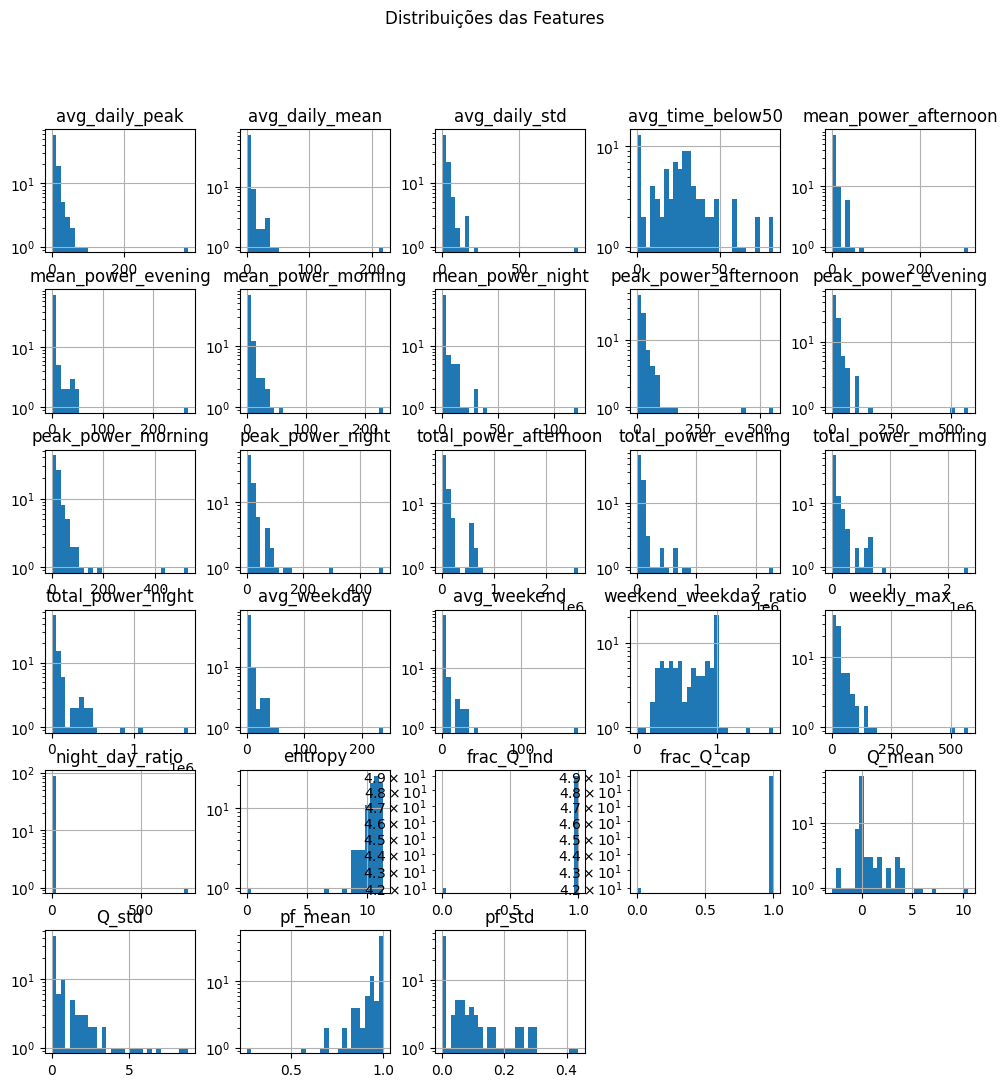

In [26]:
feat = features_final.copy()
feat = feat.reset_index()

feat.select_dtypes(include=["float","int"]).hist(
    figsize=(12,12), bins=30, log=True
)
plt.suptitle("Distribuições das Features")
plt.show()

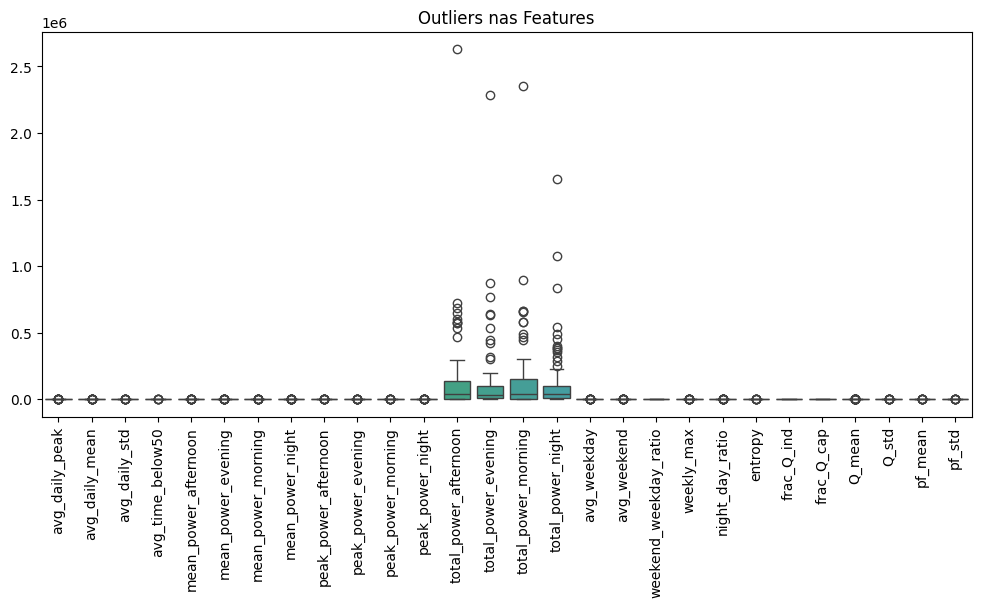

In [27]:
plt.figure(figsize=(12,5))
sns.boxplot(data=feat.select_dtypes(include=["float","int"]))
plt.xticks(rotation=90)
plt.title("Outliers nas Features")
plt.show()

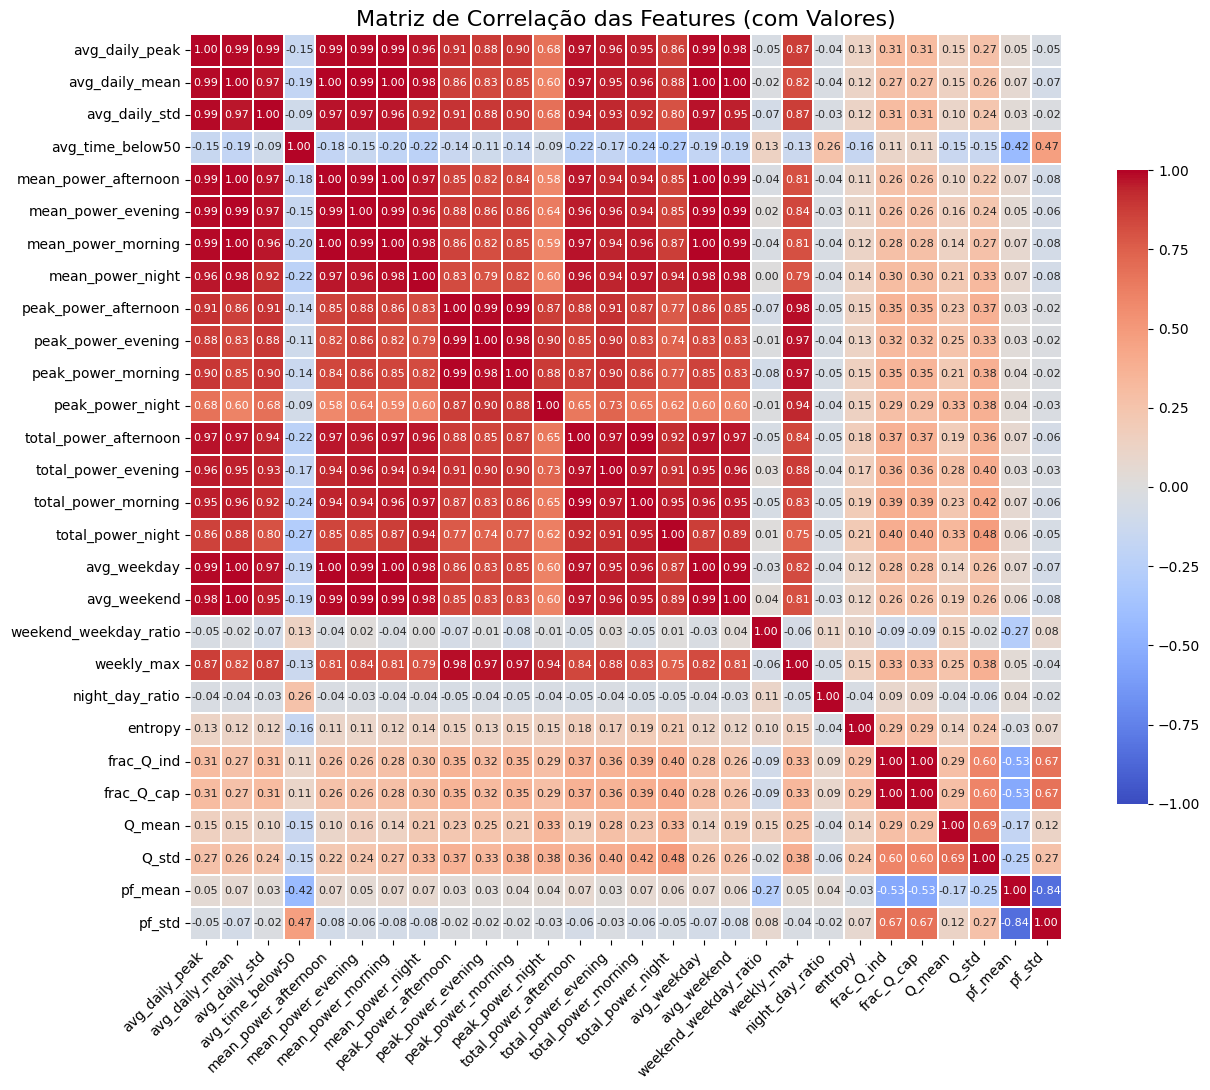

In [28]:
feat_num = feat.select_dtypes(include=["float", "int"])

plt.figure(figsize=(13,11))

sns.heatmap(
    feat_num.corr(),
    cmap="coolwarm",
    annot=True,           
    fmt=".2f",             
    annot_kws={"size": 8}, 
    linewidths=0.3,
    cbar_kws={"shrink": 0.7},
    vmin=-1.0,
    vmax=1.0
)

plt.title("Matriz de Correlação das Features (com Valores)", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [29]:
corr_target = feat_num.corr()["avg_daily_mean"].sort_values(ascending=False)
corr_target

avg_daily_mean           1.000000
avg_weekday              0.999576
mean_power_morning       0.998271
mean_power_afternoon     0.996872
avg_weekend              0.995041
mean_power_evening       0.992918
avg_daily_peak           0.989876
mean_power_night         0.981573
total_power_afternoon    0.972021
avg_daily_std            0.967591
total_power_morning      0.958014
total_power_evening      0.951002
total_power_night        0.879176
peak_power_afternoon     0.861216
peak_power_morning       0.849349
peak_power_evening       0.829750
weekly_max               0.819002
peak_power_night         0.604678
frac_Q_ind               0.273200
frac_Q_cap               0.273200
Q_std                    0.258138
Q_mean                   0.148233
entropy                  0.117879
pf_mean                  0.067888
weekend_weekday_ratio   -0.016253
night_day_ratio         -0.035893
pf_std                  -0.071942
avg_time_below50        -0.186883
Name: avg_daily_mean, dtype: float64

In [30]:
corr = feat_num.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), 1).astype(bool))

redundantes = [col for col in upper.columns if any(upper[col] > 0.95)]
redundantes

['avg_daily_mean',
 'avg_daily_std',
 'mean_power_afternoon',
 'mean_power_evening',
 'mean_power_morning',
 'mean_power_night',
 'peak_power_evening',
 'peak_power_morning',
 'total_power_afternoon',
 'total_power_evening',
 'total_power_morning',
 'total_power_night',
 'avg_weekday',
 'avg_weekend',
 'weekly_max',
 'frac_Q_cap']

In [31]:

cols_to_remove = [
    "weekly_max",
    "night_day_ratio",
    "entropy",
    "frac_Q_ind",
    "frac_Q_cap",
    "Q_mean",
    "Q_std",
    "pf_mean",
    "pf_std",
]

for col in cols_to_remove:
    if col in features_final.columns:
        features_final = features_final.drop(columns=[col])

#  WEEKLY MAX

weekly_max = (
    prep_pdf.groupby("CPE")["PotActiva"]
    .max()
    .rename("weekly_max")
)


#  NIGHT-DAY RATIO

prep_pdf["period"] = prep_pdf["hour"].apply(periodo)

period_totals = (
    prep_pdf.groupby(["CPE", "period"])["PotActiva"]
    .sum()
    .unstack(fill_value=0)
)

period_totals["night_day_ratio"] = (
    period_totals["night"] /
    (period_totals["morning"] + period_totals["afternoon"] + 1e-6)
)

night_day_ratio = period_totals["night_day_ratio"]


# ENTROPY FEATURE

def calc_entropy(series):
    p = series.values
    p = p[p > 0]
    if len(p) == 0:
        return 0.0
    p = p / p.sum()
    return entropy(p)

entropy_feature = (
    prep_pdf.groupby("CPE")["PotActiva"]
    .apply(calc_entropy)
    .rename("entropy")
)


#  FEATURES DE POTÊNCIA REATIVA

react_df = prep_pdf.copy()

react_df["has_Q_ind"] = react_df["PotReactIndut"].notna().astype(float)
react_df["has_Q_cap"] = react_df["PotReactCapac"].notna().astype(float)

mask_Q = react_df["PotReactIndut"].notna() | react_df["PotReactCapac"].notna()

react_df.loc[mask_Q, "Q_total"] = (
    react_df["PotReactIndut"].fillna(0)
    - react_df["PotReactCapac"].fillna(0)
)

mask_PQ = mask_Q & react_df["PotActiva"].notna()
P = react_df.loc[mask_PQ, "PotActiva"]
Q = react_df.loc[mask_PQ, "Q_total"]
react_df.loc[mask_PQ, "PF"] = P / np.sqrt(P**2 + Q**2)

react_features = (
    react_df.groupby("CPE")
    .agg({
        "has_Q_ind": "mean",
        "has_Q_cap": "mean",
        "Q_total": ["mean", "std"],
        "PF": ["mean", "std"],
    })
)

react_features.columns = [
    "frac_Q_ind",
    "frac_Q_cap",
    "Q_mean",
    "Q_std",
    "pf_mean",
    "pf_std",
]

react_features = react_features.fillna({
    "frac_Q_ind": 0.0,
    "frac_Q_cap": 0.0,
    "Q_mean": 0.0,
    "Q_std": 0.0,
    "pf_mean": 1.0,
    "pf_std": 0.0,
})


#  FEATURES FINAIS
features_final = (
    features_final
    .join(weekly_max, how="left")
    .join(night_day_ratio, how="left")
    .join(entropy_feature, how="left")
    .join(react_features, how="left")   # <--- AQUI ESTÃO AS NOVAS FEATURES
)

print("Features adicionadas com sucesso!")
print(features_final.head())


Features adicionadas com sucesso!
                      avg_daily_peak  avg_daily_mean  avg_daily_std  \
CPE                                                                   
PT0002000032936306KX        5.334452        2.451701       2.546508   
PT0002000032942455NH        0.257027        0.090997       0.054953   
PT0002000032959511HP        0.000000        0.000000       0.000000   
PT0002000032966446CC        0.322175        0.099622       0.066023   
PT0002000032968749YT       11.542965        3.636439       2.627443   

                      avg_time_below50  mean_power_afternoon  \
CPE                                                            
PT0002000032936306KX         47.155779              0.004103   
PT0002000032942455NH         20.579104              0.097075   
PT0002000032959511HP          0.000000              0.000000   
PT0002000032966446CC         22.942623              0.098169   
PT0002000032968749YT         23.951754              5.214901   

                   

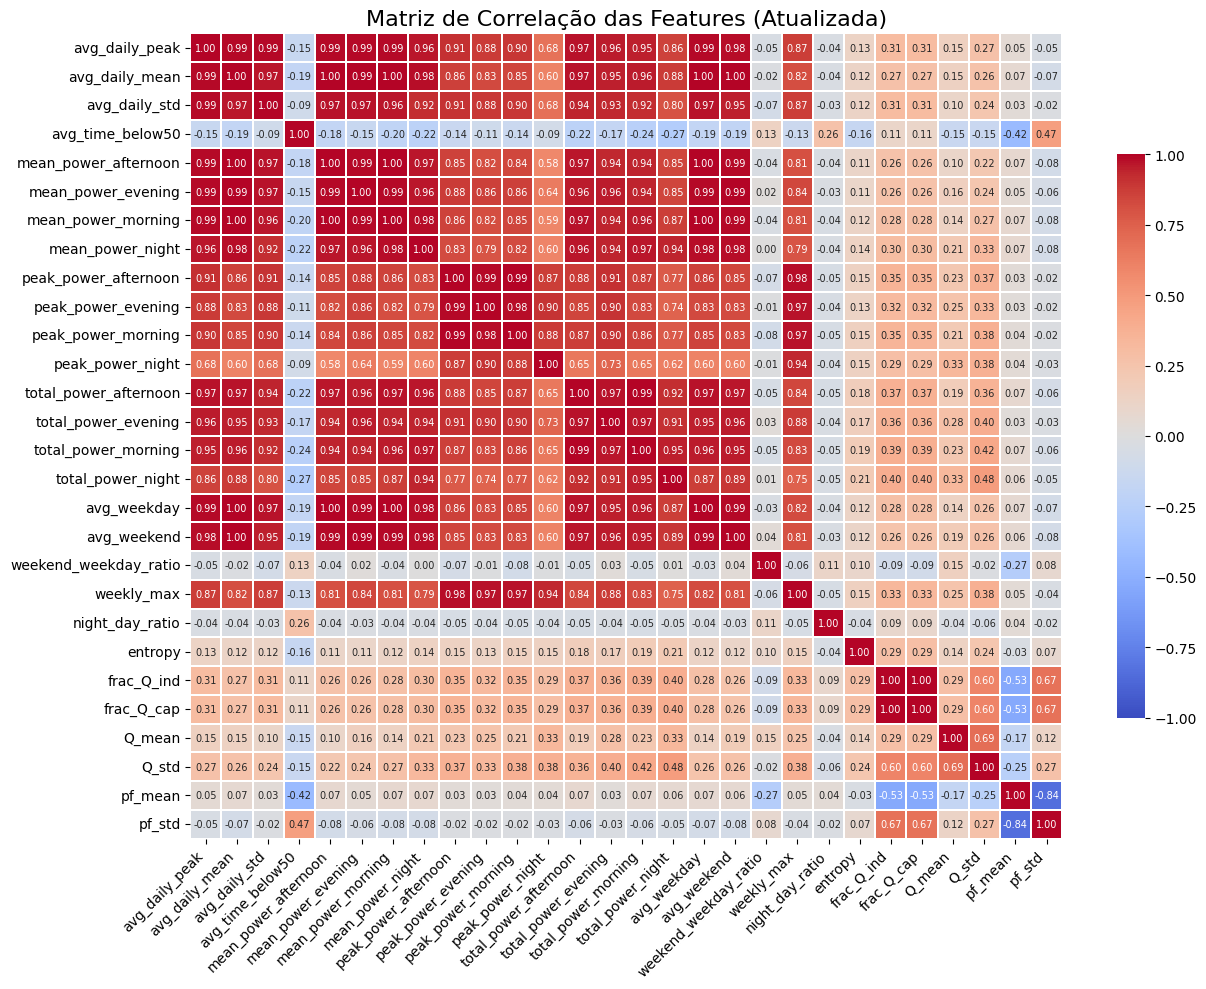

In [32]:
featupdated = features_final.copy().reset_index()

feat_num_updated = featupdated.select_dtypes(include=["float", "int"])

plt.figure(figsize=(13,10))

sns.heatmap(
    feat_num_updated.corr(),
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    annot_kws={"size": 7},
    linewidths=0.3,
    cbar_kws={"shrink": 0.7},
    vmin=-1.0,
    vmax=1.0
)

plt.title("Matriz de Correlação das Features (Atualizada)", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [33]:
features_raw = features_final.copy()
feat_num = features_raw.select_dtypes(include=["float", "int"])
corr = feat_num.corr().abs()

upper = corr.where(np.triu(np.ones(corr.shape), 1).astype(bool))

to_drop = [
    column 
    for column in upper.columns 
    if any(upper[column] > 0.95)
]

# Manter apenas features que não estão na lista to_drop
features_clean = features_raw.drop(columns=to_drop)

print("Removidas:", to_drop)
print("Total antes:", features_raw.shape[1])
print("Total depois:", features_clean.shape[1])

Removidas: ['avg_daily_mean', 'avg_daily_std', 'mean_power_afternoon', 'mean_power_evening', 'mean_power_morning', 'mean_power_night', 'peak_power_evening', 'peak_power_morning', 'total_power_afternoon', 'total_power_evening', 'total_power_morning', 'total_power_night', 'avg_weekday', 'avg_weekend', 'weekly_max', 'frac_Q_cap']
Total antes: 28
Total depois: 12


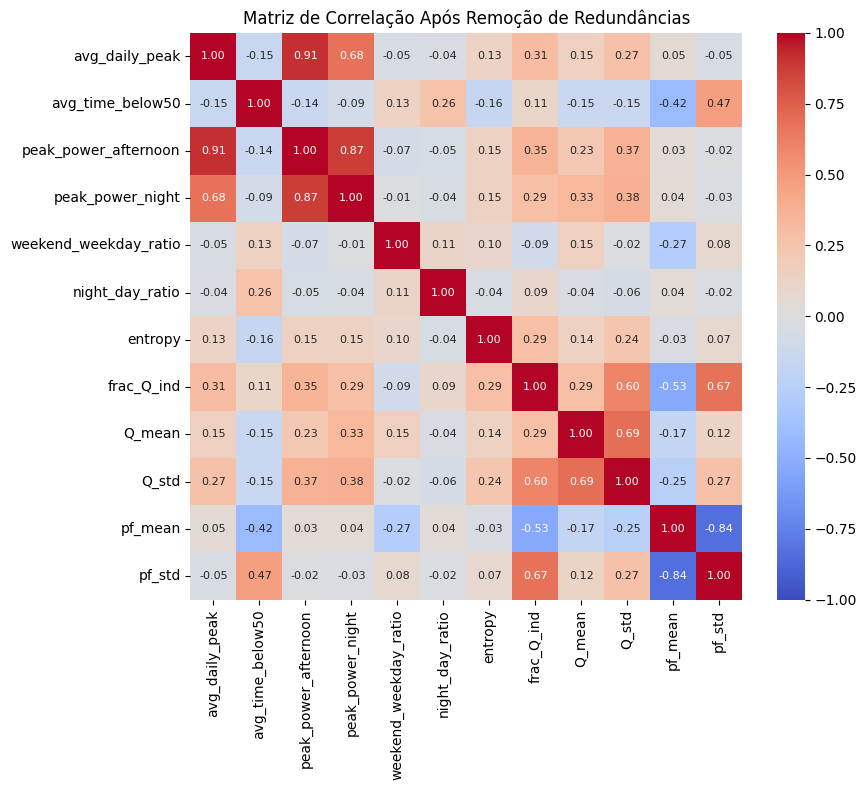

In [34]:
feat_num_clean = features_clean.select_dtypes(include=["float", "int"])

plt.figure(figsize=(9,8))
sns.heatmap(
    feat_num_clean.corr(),
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    annot_kws={"size":8},
    vmin=-1.0,
    vmax=1.0
)
plt.title("Matriz de Correlação Após Remoção de Redundâncias")
plt.tight_layout()
plt.show()

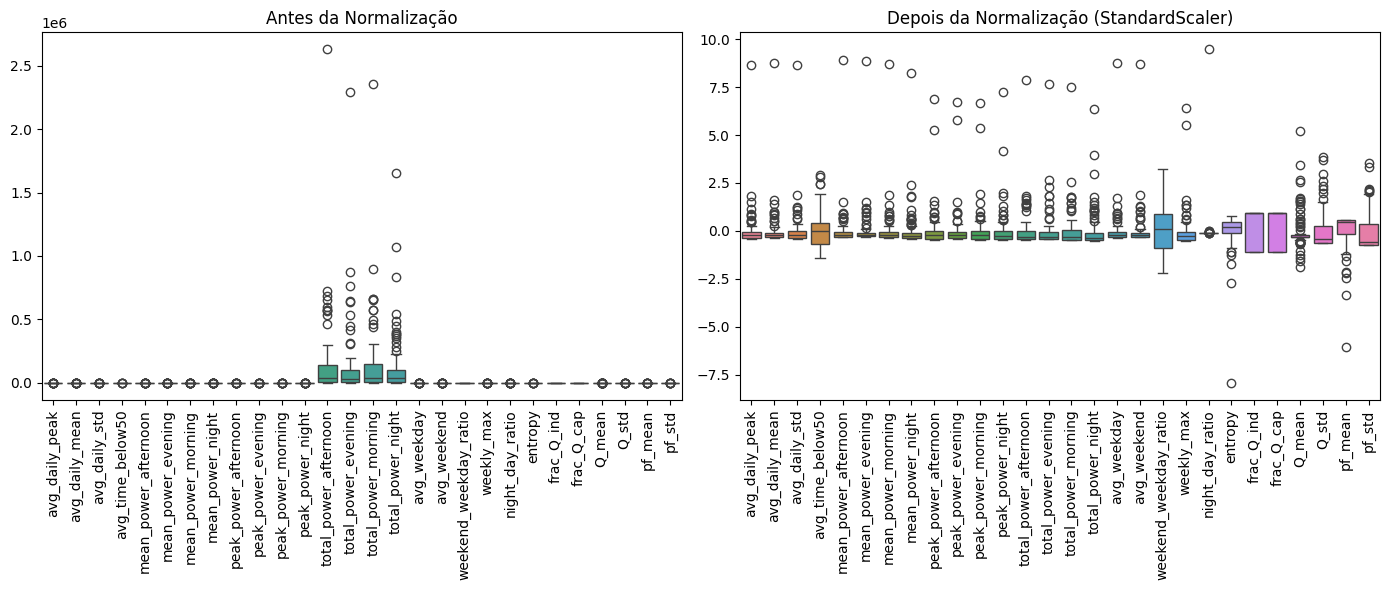

In [35]:
# Selecionar apenas features numéricas
feat = features_final.copy()
feat_num = feat.select_dtypes(include=["float", "int"])

# Remover linhas com NaN (necessário para o PCA)
feat_pca = feat_num.dropna()

# Normalização correta
scaler = StandardScaler()
feat_scaled = pd.DataFrame(
    scaler.fit_transform(feat_pca),
    index=feat_pca.index,
    columns=feat_pca.columns
)

# BOX-PLOT ANTES E DEPOIS

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.boxplot(data=feat_pca)
plt.title("Antes da Normalização")
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.boxplot(data=feat_scaled)
plt.title("Depois da Normalização (StandardScaler)")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

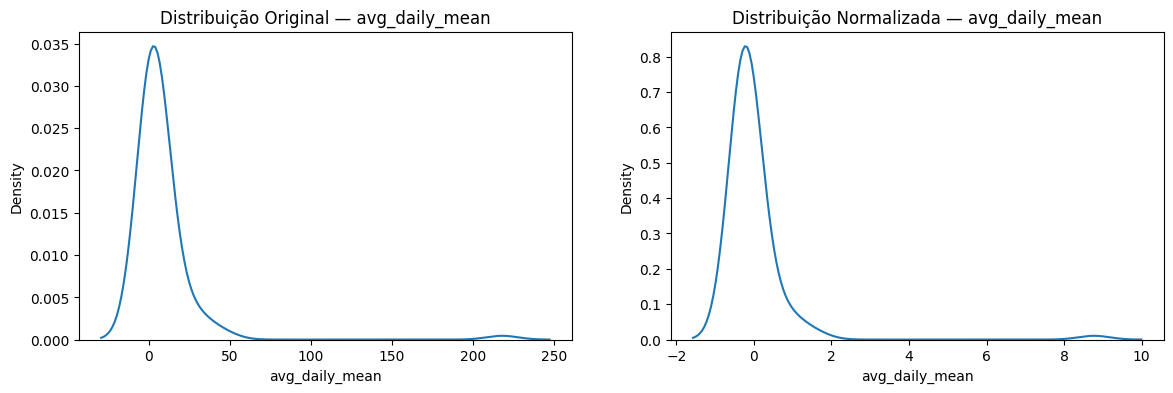

In [36]:
# distribuições antes e depois da normalização do avg_daily_mean

fig, ax = plt.subplots(1, 2, figsize=(14,4))

sns.kdeplot(feat_pca["avg_daily_mean"], ax=ax[0])
sns.kdeplot(feat_scaled["avg_daily_mean"], ax=ax[1])

ax[0].set_title("Distribuição Original — avg_daily_mean")
ax[1].set_title("Distribuição Normalizada — avg_daily_mean")

plt.show()

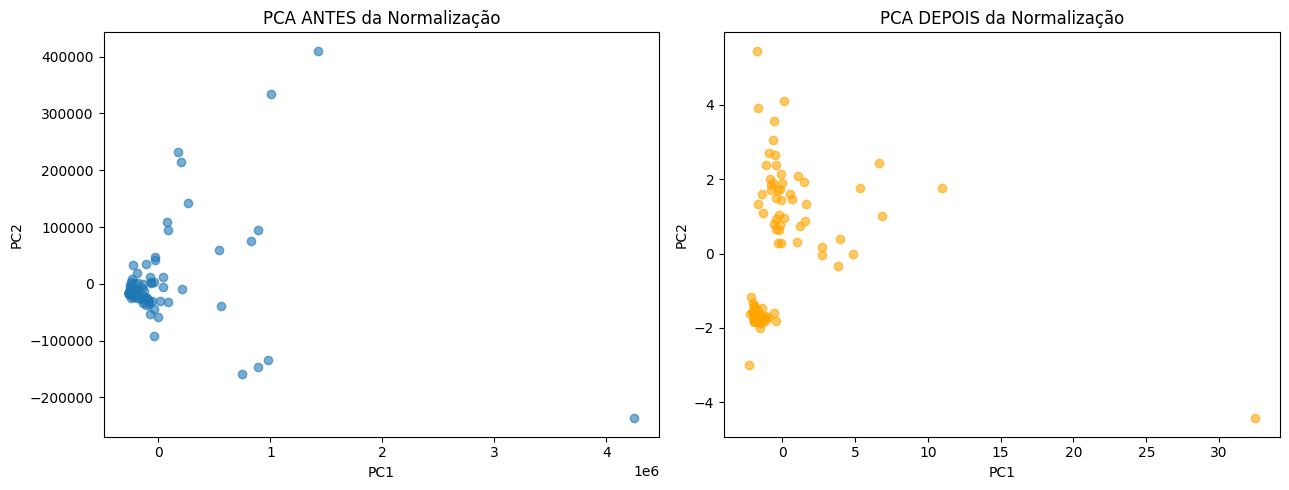

In [37]:
# PCA ANTES E DEPOIS 

pca1 = PCA(n_components=2)
pca_before = pca1.fit_transform(feat_pca)

pca2 = PCA(n_components=2)
pca_after  = pca2.fit_transform(feat_scaled)

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.scatter(pca_before[:,0], pca_before[:,1], alpha=0.6)
plt.title("PCA ANTES da Normalização")
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.subplot(1,2,2)
plt.scatter(pca_after[:,0], pca_after[:,1], alpha=0.6, color="orange")
plt.title("PCA DEPOIS da Normalização")
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.tight_layout()
plt.show()

In [38]:
feat_num = features_final.select_dtypes(include=["float","int"])

# Remover NaN
feat_clust = feat_num.dropna()

# Normalizar
scaler = StandardScaler()
feat_scaled = scaler.fit_transform(feat_clust)

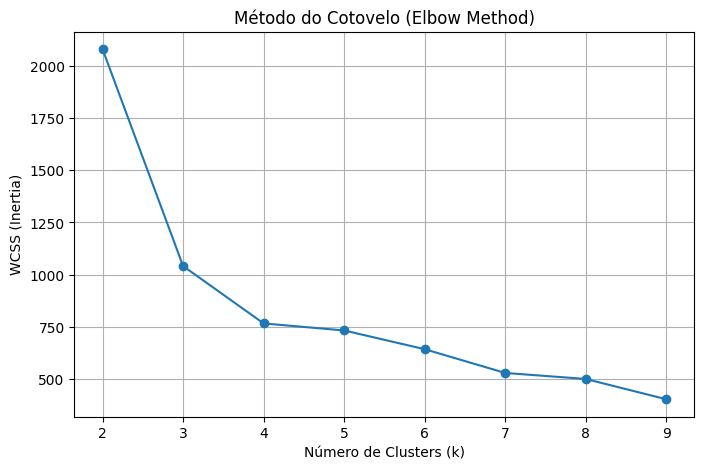

In [39]:
wcss = []  # Within-cluster sum of squares

K = range(2, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(feat_scaled)
    wcss.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, wcss, marker='o')
plt.xlabel("Número de Clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.title("Método do Cotovelo (Elbow Method)")
plt.grid(True)
plt.show()


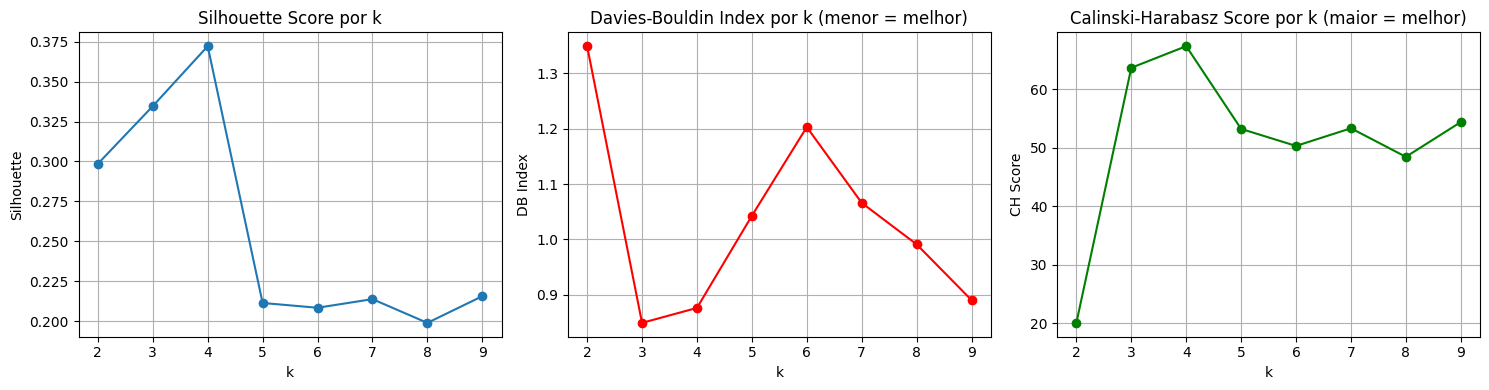

{'Silhouette': {2: 0.2985447313570785,
  3: 0.3346773027099711,
  4: 0.37223972377841325,
  5: 0.2113659516992493,
  6: 0.20837069595515018,
  7: 0.2137743630768845,
  8: 0.19889128787725655,
  9: 0.21559395260403127},
 'Davies-Bouldin': {2: 1.3493392889801015,
  3: 0.8491146730724694,
  4: 0.8761785715544264,
  5: 1.0426677414693768,
  6: 1.203073480376964,
  7: 1.0661127117744422,
  8: 0.9911062064919283,
  9: 0.8902849963045877},
 'Calinski-Harabasz': {2: 20.09303974721062,
  3: 63.69087530963052,
  4: 67.3854494768209,
  5: 53.24422669182219,
  6: 50.33590216911589,
  7: 53.352232527514,
  8: 48.471866890412585,
  9: 54.41346738215947}}

In [40]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

sil_scores = {}
dbi_scores = {}
chi_scores = {}

for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(feat_scaled)

    # Silhouette
    sil_scores[k] = silhouette_score(feat_scaled, labels)

    # Davies-Bouldin (menor = melhor)
    dbi_scores[k] = davies_bouldin_score(feat_scaled, labels)

    # Calinski-Harabasz (maior = melhor)
    chi_scores[k] = calinski_harabasz_score(feat_scaled, labels)



plt.figure(figsize=(15,4))

# Silhouette
plt.subplot(1,3,1)
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.title("Silhouette Score por k")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.grid(True)

# Davies–Bouldin
plt.subplot(1,3,2)
plt.plot(list(dbi_scores.keys()), list(dbi_scores.values()), marker='o', color='red')
plt.title("Davies-Bouldin Index por k (menor = melhor)")
plt.xlabel("k")
plt.ylabel("DB Index")
plt.grid(True)

# Calinski-Harabasz
plt.subplot(1,3,3)
plt.plot(list(chi_scores.keys()), list(chi_scores.values()), marker='o', color='green')
plt.title("Calinski-Harabasz Score por k (maior = melhor)")
plt.xlabel("k")
plt.ylabel("CH Score")
plt.grid(True)

plt.tight_layout()
plt.show()

# Mostrar valores numéricos
{"Silhouette": sil_scores, "Davies-Bouldin": dbi_scores, "Calinski-Harabasz": chi_scores}


In [41]:
best_k = 4

kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(feat_scaled)

feat_clust.loc[:, "cluster"] = cluster_labels

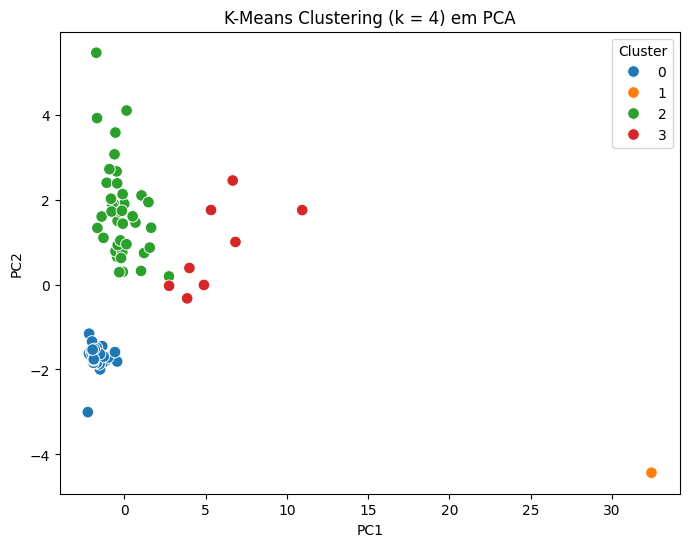

In [42]:
pca = PCA(n_components=2)
coords = pca.fit_transform(feat_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=coords[:,0], y=coords[:,1],
    hue=cluster_labels,
    palette='tab10',
    s=70
)

plt.title(f"K-Means Clustering (k = {best_k}) em PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

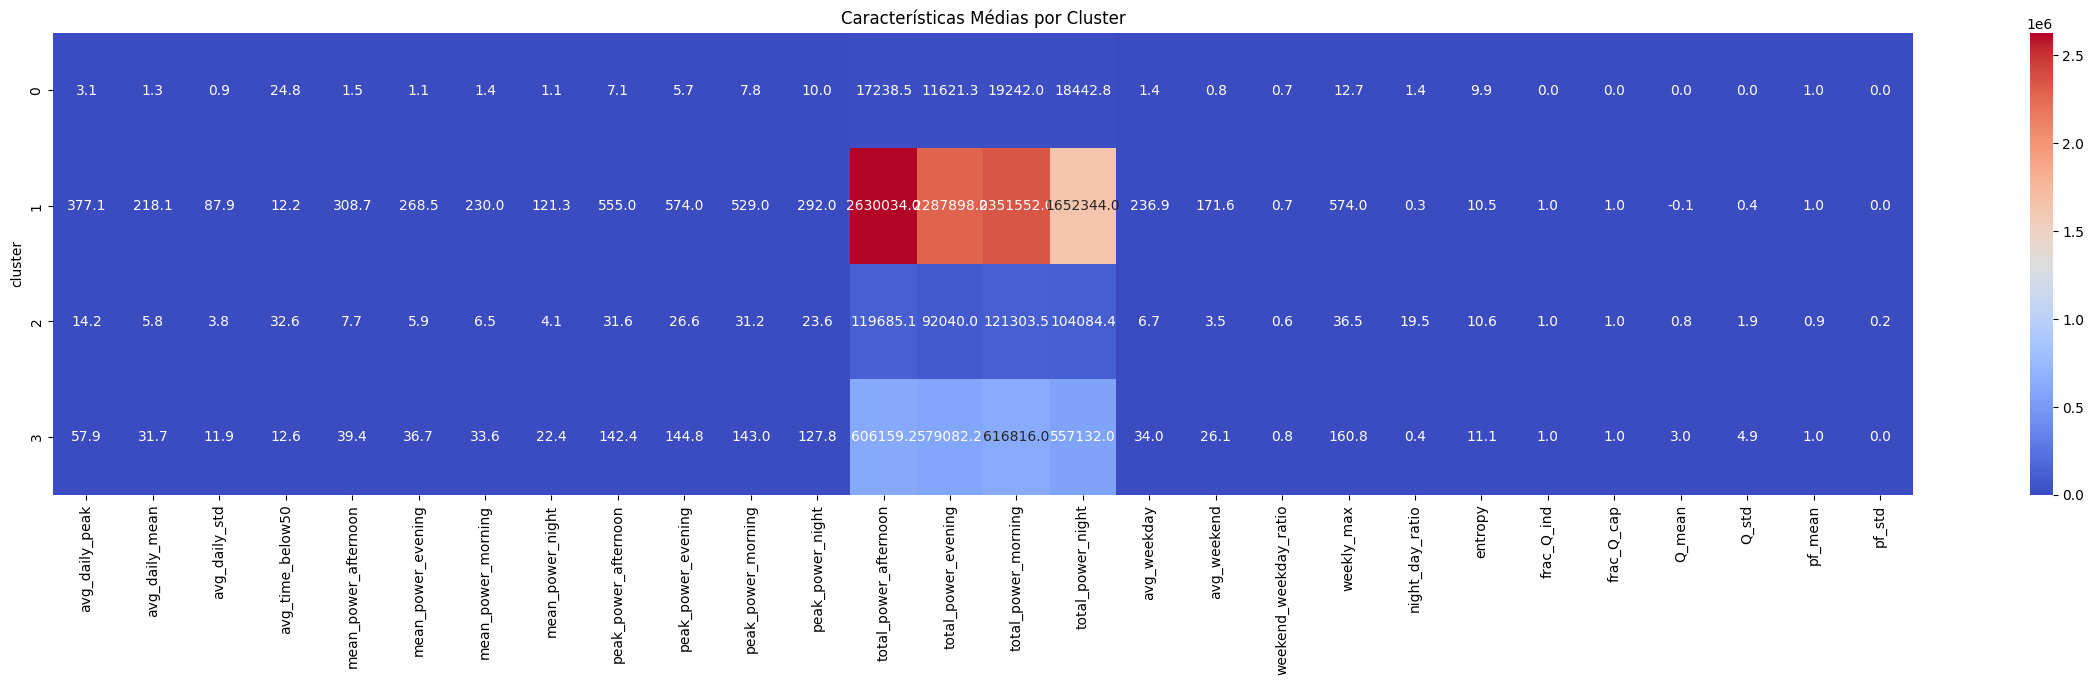

In [43]:
cluster_summary = feat_clust.groupby("cluster").mean()
cluster_summary

plt.figure(figsize=(30,6))
sns.heatmap(cluster_summary, cmap="coolwarm", annot=True, fmt=".1f")
plt.title("Características Médias por Cluster")
plt.show()

In [44]:
cluster_sizes = feat_clust["cluster"].value_counts().sort_index()

summary_for_report = pd.DataFrame({
    "N_CPE": cluster_sizes,
    "avg_daily_mean": cluster_summary["avg_daily_mean"],
    "weekly_max": cluster_summary["weekly_max"],
    "total_power": (
        cluster_summary["total_power_morning"] +
        cluster_summary["total_power_afternoon"] +
        cluster_summary["total_power_evening"] +
        cluster_summary["total_power_night"]
    ),
    "weekend_weekday_ratio": cluster_summary["weekend_weekday_ratio"],
    "night_day_ratio": cluster_summary["night_day_ratio"],
})
summary_for_report

,N_CPE,avg_daily_mean,weekly_max,total_power,weekend_weekday_ratio,night_day_ratio
cluster,,,,,,
0,42,1.264969,12.667524,6.654451e+04,0.723019,1.378051
1,1,218.081217,574.000000,8.921828e+06,0.724585,0.331690
2,40,5.813299,36.525000,4.371130e+05,0.643205,19.530457
3,8,31.700381,160.750000,2.359190e+06,0.781860,0.444208


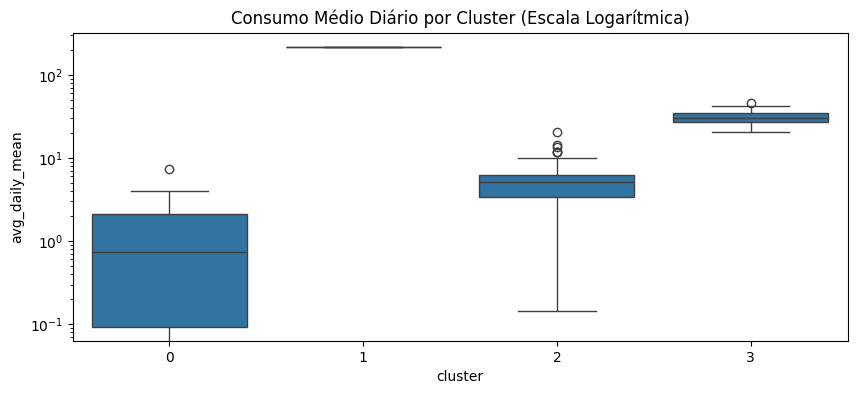

In [45]:
plt.figure(figsize=(10,4))
sns.boxplot(data=feat_clust, x="cluster", y="avg_daily_mean")
plt.yscale("log")
plt.title("Consumo Médio Diário por Cluster (Escala Logarítmica)")
plt.show()

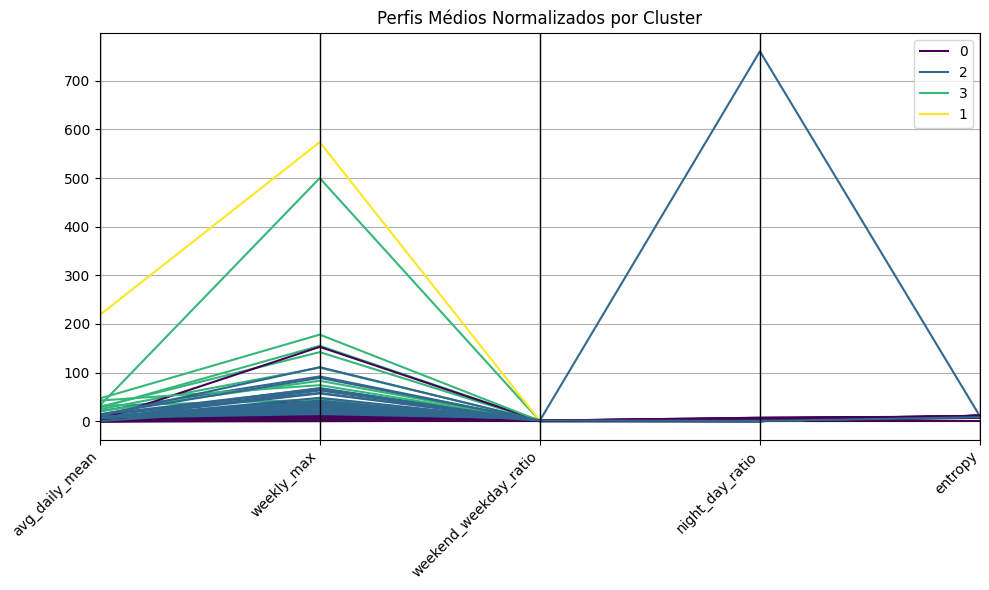

In [46]:
from pandas.plotting import parallel_coordinates

# 1) Copiar o dataframe com clusters
df_plot = feat_clust.copy()          # feat_clust é o teu dataframe com as features + "cluster"

# 2) Se houver índice (CPE), trazer para coluna normal
df_plot = df_plot.reset_index()      # se o CPE estiver no índice

# 3) Garantir que TODOS os nomes de colunas são strings
df_plot.columns = df_plot.columns.map(str)

# 4) Garantir que "cluster" é string (classe categórica)
df_plot["cluster"] = df_plot["cluster"].astype(str)

# 5) (Opcional) escolher apenas algumas features para não ficar caótico
cols_features = [
    "avg_daily_mean",
    "weekly_max",
    "weekend_weekday_ratio",
    "night_day_ratio",
    "entropy",
]

# Construir dataframe final para o gráfico: classe + features
df_pc = df_plot[["cluster"] + cols_features]

# 6) Parallel coordinates
plt.figure(figsize=(10, 6))
parallel_coordinates(
    df_pc,
    class_column="cluster",
    colormap="viridis"
)
plt.xticks(rotation=45, ha="right")
plt.title("Perfis Médios Normalizados por Cluster")
plt.tight_layout()
plt.show()

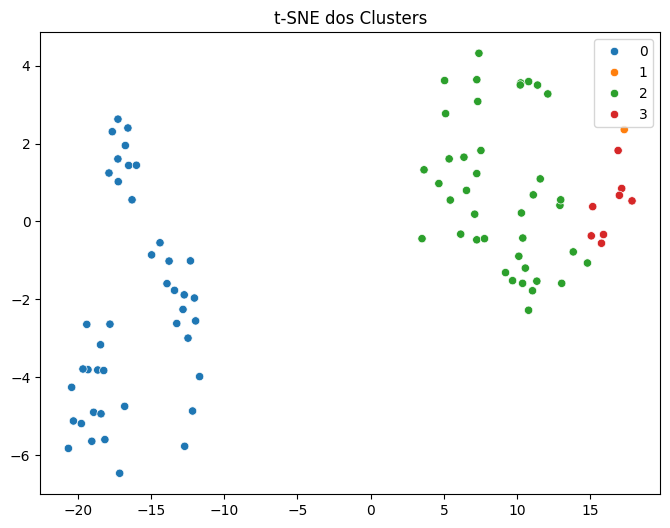

In [47]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=15, random_state=42)
coords_tsne = tsne.fit_transform(feat_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=coords_tsne[:,0], y=coords_tsne[:,1],
    hue=cluster_labels, palette="tab10"
)
plt.title("t-SNE dos Clusters")
plt.show()

O PCA permite representar os dados num espaço de 2 dimensões maximizando a variância, mas não preserva relações de proximidade entre os pontos.
Por isso, pode distorcer a estrutura real dos clusters.

Para avaliar se os clusters encontrados são realmente separados no espaço original, é preferível usar métodos não lineares como o t-SNE, que preservam vizinhanças e evidenciam agrupamentos naturais.

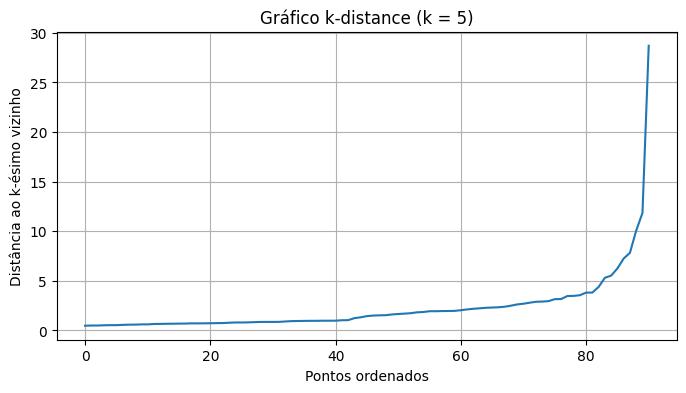

In [48]:
from sklearn.neighbors import NearestNeighbors

min_samples = 5  # ponto de partida razoável

neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(feat_scaled)
distances, indices = neighbors_fit.kneighbors(feat_scaled)

# Fica com a distância ao k-ésimo vizinho (última coluna)
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(8,4))
plt.plot(k_distances)
plt.title(f"Gráfico k-distance (k = {min_samples})")
plt.xlabel("Pontos ordenados")
plt.ylabel("Distância ao k-ésimo vizinho")
plt.grid(True)
plt.show()

In [49]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np

eps_values = [0.3, 0.5, 0.7, 1.0, 1.5]        # adapta com base no gráfico
min_samples_values = [3, 5, 7, 9, 10]

results = []

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(feat_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_frac = np.mean(labels == -1)

        # Silhouette só se houver pelo menos 2 clusters e nem tudo for ruído
        if n_clusters >= 2 and noise_frac < 0.95:
            mask = labels != -1
            sil = silhouette_score(feat_scaled[mask], labels[mask])
        else:
            sil = np.nan

        results.append({
            "eps": eps,
            "min_samples": ms,
            "n_clusters": n_clusters,
            "noise_frac": noise_frac,
            "silhouette": sil
        })

results_df = pd.DataFrame(results)
results_df

,eps,min_samples,n_clusters,noise_frac,silhouette
0,0.3,3,1,0.945055,NaN
1,0.3,5,0,1.000000,NaN
2,0.3,7,0,1.000000,NaN
3,0.3,9,0,1.000000,NaN
4,0.3,10,0,1.000000,NaN
5,0.5,3,3,0.824176,0.724559
6,0.5,5,1,0.912088,NaN
7,0.5,7,0,1.000000,NaN
8,0.5,9,0,1.000000,NaN
9,0.5,10,0,1.000000,NaN


In [50]:
best_eps = 0.5
best_min_samples = 3

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels_db = dbscan.fit_predict(feat_scaled)

# Copiar o dataframe de features (sem NaN) e adicionar o cluster DBSCAN
feat_db = feat_clust.copy()
feat_db = feat_db.reset_index()  # se o CPE estiver no índice
feat_db["cluster_dbscan"] = labels_db

# Ver quantos clusters + ruído
print("Labels únicos:", sorted(set(labels_db)))
print("N.º de clusters (sem ruído):", len(set(labels_db)) - (1 if -1 in labels_db else 0))
print("Percentagem de ruído:", np.mean(labels_db == -1))

Labels únicos: [-1, 0, 1, 2]
N.º de clusters (sem ruído): 3
Percentagem de ruído: 0.8241758241758241


In [51]:
pca = PCA(n_components=2)
coords = pca.fit_transform(feat_scaled)

tsne = TSNE(n_components=2, perplexity=15, random_state=42)
coords_tsne = tsne.fit_transform(feat_scaled)

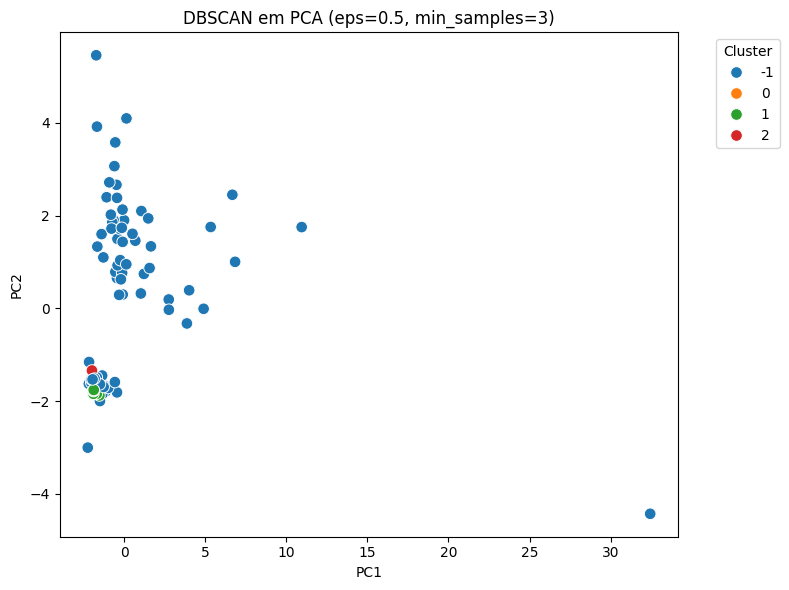

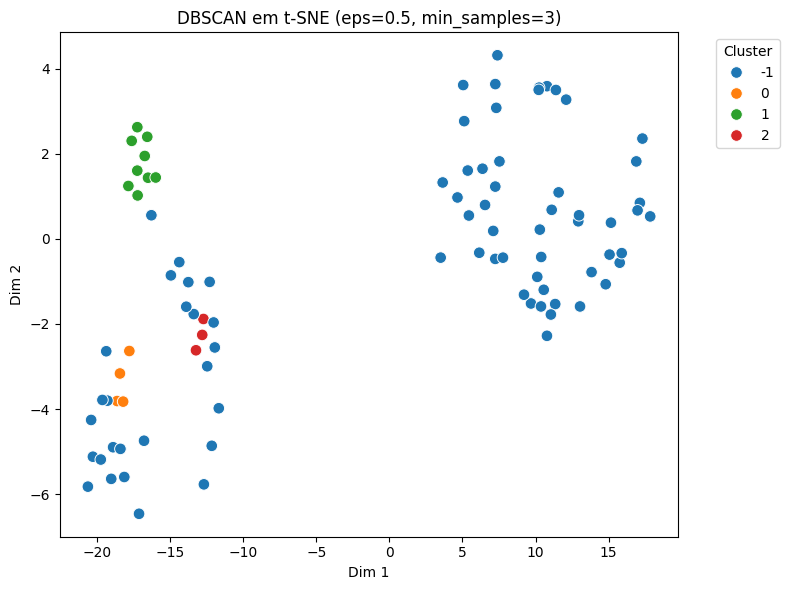

In [52]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=coords[:,0], y=coords[:,1],
    hue=labels_db,
    palette="tab10",
    s=70
)
plt.title(f"DBSCAN em PCA (eps={best_eps}, min_samples={best_min_samples})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=coords_tsne[:,0], y=coords_tsne[:,1],
    hue=labels_db,
    palette="tab10",
    s=70
)
plt.title(f"DBSCAN em t-SNE (eps={best_eps}, min_samples={best_min_samples})")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [54]:
# Remover ruído
feat_db_valid = feat_db[feat_db["cluster_dbscan"] != -1]

# Selecionar só colunas numéricas
feat_db_valid_num = feat_db_valid.select_dtypes(include=["float", "int"]).copy()

# Reintroduzir a coluna cluster
feat_db_valid_num["cluster_dbscan"] = feat_db_valid["cluster_dbscan"].values

# Agora é seguro calcular a média
cluster_summary_db = (
    feat_db_valid_num
    .groupby("cluster_dbscan")
    .mean()
)

cluster_sizes_db = feat_db_valid["cluster_dbscan"].value_counts().sort_index()

summary_for_report_db = pd.DataFrame({
    "N_CPE": cluster_sizes_db,
    "avg_daily_mean": cluster_summary_db["avg_daily_mean"],
    "weekly_max": cluster_summary_db["weekly_max"],
    "total_power": (
        cluster_summary_db["total_power_morning"] +
        cluster_summary_db["total_power_afternoon"] +
        cluster_summary_db["total_power_evening"] +
        cluster_summary_db["total_power_night"]
    ),
    "weekend_weekday_ratio": cluster_summary_db["weekend_weekday_ratio"],
    "night_day_ratio": cluster_summary_db["night_day_ratio"],
})

summary_for_report_db


,N_CPE,avg_daily_mean,weekly_max,total_power,weekend_weekday_ratio,night_day_ratio
cluster_dbscan,,,,,,
0,4,0.669753,5.427000,34970.521000,0.555063,0.448687
1,9,0.575849,3.427556,30602.560889,0.952720,0.582382
2,3,0.495004,2.118667,26262.740000,1.005501,3.599075


### Supervised

In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA

# Função para extrair série temporal limpa de um CPE
def get_series_for_cpe(prep_pdf, cpe):
    s = (
        prep_pdf[prep_pdf["CPE"] == cpe]
        .sort_values("tstamp")
        .set_index("tstamp")["PotActiva"]
    )
    # Garantir frequência fixa de 15 minutos
    s = s.asfreq("15min")
    # Tratar missing de forma simples
    s = s.interpolate(limit_direction="both")
    return s

# Função para partir em 70% / 30% temporal
def split_series_train_test(s, train_frac=0.7):
    n = len(s)
    cutoff = int(n * train_frac)
    train = s.iloc[:cutoff]
    test  = s.iloc[cutoff:]
    return train, test


In [ ]:
def baseline_week_before(train, test):
    # juntamos para ter índice contínuo
    full = pd.concat([train, test])
    
    # 1 semana = 96*7 passos de 15 min
    lag = 96 * 7
    
    # previsão = valor observado 1 semana antes
    baseline_full = full.shift(lag)
    
    # baseline apenas para a parte de teste
    baseline_test = baseline_full.loc[test.index]
    
    # limpar casos sem histórico suficiente
    mask = ~baseline_test.isna()
    y_true = test[mask]
    y_pred = baseline_test[mask]
    
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse, y_true, y_pred



=== CPE PT0002000078441876HB ===
Baseline (1 semana) - MAE=43.098, RMSE=60.869


C:\Users\João Oliveira\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3,1,3)(2,1,1,24) - MAE=93.518, RMSE=111.189


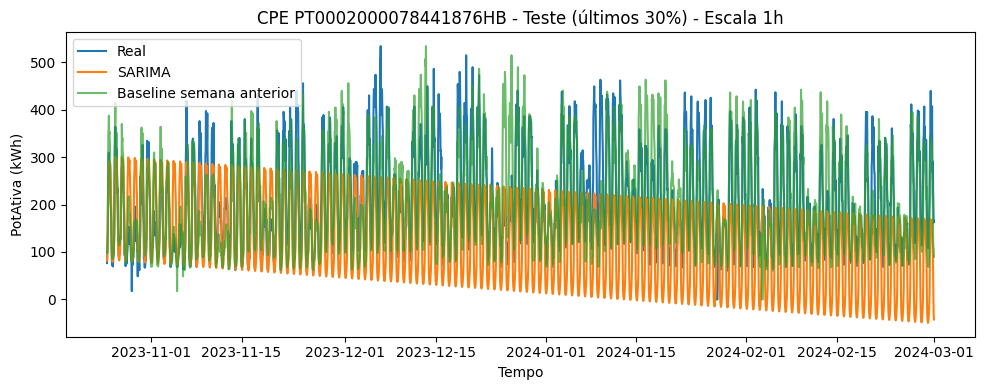


=== CPE PT0002000100113293JT ===
Baseline (1 semana) - MAE=4.120, RMSE=9.850


C:\Users\João Oliveira\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ValueError: Input contains NaN.

In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Função para extrair série temporal limpa de um CPE
def get_series_for_cpe(prep_pdf, cpe):
    s = (
        prep_pdf[prep_pdf["CPE"] == cpe]
        .sort_values("tstamp")
        .set_index("tstamp")["PotActiva"]
    )
    s = s.asfreq("15min")
    s = s.interpolate(limit_direction="both")
    return s

# Train/test split temporal
def split_series_train_test(s, train_frac=0.7):
    n = len(s)
    cutoff = int(n * train_frac)
    return s.iloc[:cutoff], s.iloc[cutoff:]

def baseline_week_before(series):
    """Baseline já após resample"""
    lag = 24 * 7   # 1 semana em dados de 1h
    shifted = series.shift(lag)
    mask = ~shifted.isna()
    return shifted[mask], series[mask]


results_arima = []
cpe_list = top3_list
for cpe in cpe_list:
    print(f"\n=== CPE {cpe} ===")

    # 1) Série original a 15 min
    s = get_series_for_cpe(prep_pdf, cpe)
    train_raw, test_raw = split_series_train_test(s, train_frac=0.7)

    # 2) Converter tudo para 1h
    train = train_raw.resample("1h").mean().interpolate()
    test  = test_raw.resample("1h").mean().interpolate()

    # 3) Baseline corretamente feita em 1h
    y_pred_base, y_true_base = baseline_week_before(pd.concat([train, test]))    
    y_pred_base = y_pred_base.loc[test.index]
    y_true_base = y_true_base.loc[test.index]

    mae_base = mean_absolute_error(y_true_base, y_pred_base)
    rmse_base = sqrt(mean_squared_error(y_true_base, y_pred_base))
    print(f"Baseline (1 semana) - MAE={mae_base:.3f}, RMSE={rmse_base:.3f}")

    # 4) SARIMA correto com sazonalidade 24 (não 96)
    model = SARIMAX(
        train,
        order=(3,1,3),
        seasonal_order=(2,1,1,24),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    model_fit = model.fit(disp=False)

    forecast = pd.Series(
        model_fit.forecast(len(test)),
        index=test.index
    )

    mae_sarima = mean_absolute_error(test, forecast)
    rmse_sarima = sqrt(mean_squared_error(test, forecast))

    print(f"SARIMA(3,1,3)(2,1,1,24) - MAE={mae_sarima:.3f}, RMSE={rmse_sarima:.3f}")

    results_arima.append({
        "CPE": cpe,
        "MAE_baseline": mae_base,
        "RMSE_baseline": rmse_base,
        "MAE_sarima": mae_sarima,
        "RMSE_sarima": rmse_sarima
    })

    # 5) Gráfico alinhado (tudo a 1h)
    plt.figure(figsize=(10,4))
    plt.plot(test.index, test.values, label="Real")
    plt.plot(forecast.index, forecast.values, label="SARIMA")
    plt.plot(y_pred_base.index, y_pred_base.values, label="Baseline semana anterior", alpha=0.7)
    plt.title(f"CPE {cpe} - Teste (últimos 30%) - Escala 1h")
    plt.xlabel("Tempo")
    plt.ylabel("PotAtiva (kWh)")
    plt.legend()
    plt.tight_layout()
    plt.show()

results_arima = pd.DataFrame(results_arima)
results_arima


In [74]:
def compute_target(prep_pdf, cpe):
    """
    Target = média da primeira semana (1h) do test-set.
    Retorna None se o test-set não tiver dados suficientes.
    """

    # Série original a 15 minutos
    s = get_series_for_cpe(prep_pdf, cpe)

    # Train/test
    train, test = split_series_train_test(s, train_frac=0.7)

    # Converter para 1h (fundamental!)
    train_h = train.resample("1h").mean().interpolate()
    test_h  = test.resample("1h").mean().interpolate()

    # 1 semana em 1h
    week = 24 * 7     # 168 valores

    if len(test_h) < week:
        return None

    return test_h.iloc[:week].mean()


In [75]:
# Criar target para todos os CPEs
targets = {}

for cpe in features_final.index:
    tgt = compute_target(prep_pdf, cpe)
    if tgt is not None:
        targets[cpe] = tgt

y = pd.Series(targets, name="target")

# Alinhar X com os índices que têm target válido
X = features_final.loc[y.index]

print("Número de CPE usados:", len(X))


Número de CPE usados: 91


In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [77]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

mae_rf  = mean_absolute_error(y_test, rf_pred)
rmse_rf = sqrt(mean_squared_error(y_test, rf_pred))

print("RANDOM FOREST:")
print(" MAE:", mae_rf)
print(" RMSE:", rmse_rf)


RANDOM FOREST:
 MAE: 2.879434074552935
 RMSE: 6.149082135983797


In [78]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

mae_xgb  = mean_absolute_error(y_test, xgb_pred)
rmse_xgb = sqrt(mean_squared_error(y_test, xgb_pred))

print("\nXGBOOST:")
print(" MAE:", mae_xgb)
print(" RMSE:", rmse_xgb)



XGBOOST:
 MAE: 2.255628419549633
 RMSE: 5.163224474451424


In [79]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(64,32),
    max_iter=500,
    random_state=42
)

mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)

mae_mlp  = mean_absolute_error(y_test, mlp_pred)
rmse_mlp = sqrt(mean_squared_error(y_test, mlp_pred))

print("\nMLP:")
print(" MAE:", mae_mlp)
print(" RMSE:", rmse_mlp)



MLP:
 MAE: 428.8261128335046
 RMSE: 957.6696941585835


C:\Users\João Oliveira\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [80]:
results = pd.DataFrame({
    "Modelo": ["Random Forest", "XGBoost", "MLP"],
    "MAE": [mae_rf, mae_xgb, mae_mlp],
    "RMSE": [rmse_rf, rmse_xgb, rmse_mlp]
})

results


,Modelo,MAE,RMSE
0,Random Forest,2.879434,6.149082
1,XGBoost,2.255628,5.163224
2,MLP,428.826113,957.669694


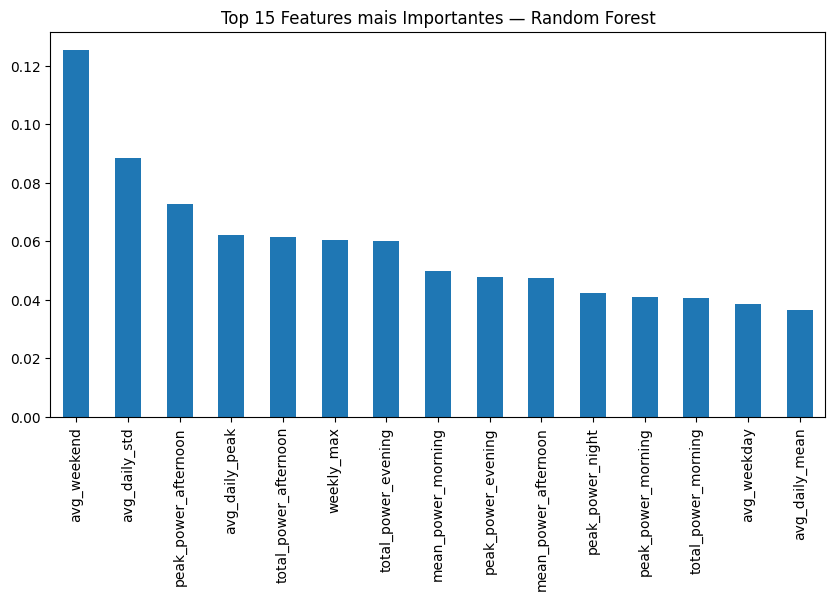

In [81]:
import matplotlib.pyplot as plt

rf_importances = pd.Series(rf.feature_importances_, index=X.columns)

plt.figure(figsize=(10,5))
rf_importances.sort_values(ascending=False).head(15).plot(kind='bar')
plt.title("Top 15 Features mais Importantes — Random Forest")
plt.show()


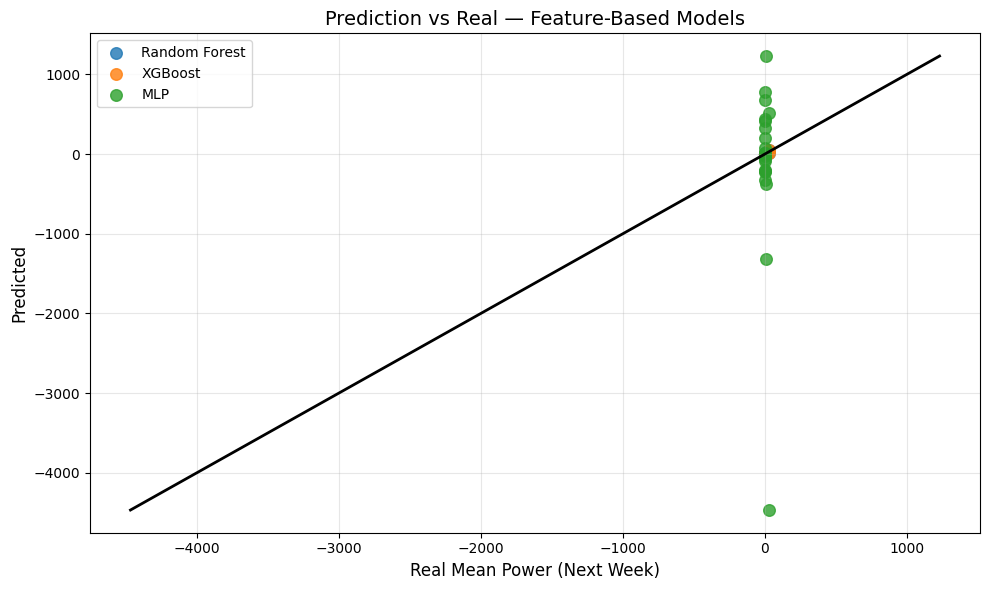

In [83]:
plt.figure(figsize=(10,6))

# Linha ideal y=x
min_v = min(y_test.min(), rf_pred.min(), xgb_pred.min(), mlp_pred.min())
max_v = max(y_test.max(), rf_pred.max(), xgb_pred.max(), mlp_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], "k-", linewidth=2)

# Pontos dos modelos
plt.scatter(y_test, rf_pred,  s=70, label="Random Forest", alpha=0.8)
plt.scatter(y_test, xgb_pred, s=70, label="XGBoost",       alpha=0.8)
plt.scatter(y_test, mlp_pred, s=70, label="MLP",           alpha=0.8)

plt.xlabel("Real Mean Power (Next Week)", fontsize=12)
plt.ylabel("Predicted", fontsize=12)
plt.title("Prediction vs Real — Feature-Based Models", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
